In [1]:
import matplotlib.pyplot as plt
import json

with open('../results/transformer/scan/addjump/addjump/train_defaults_jump0.json', 'r') as f:
    transformer_res = json.load(f)

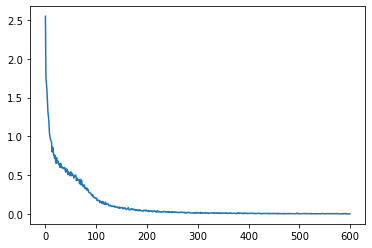

In [2]:
plt.plot(transformer_res['loss_data'])

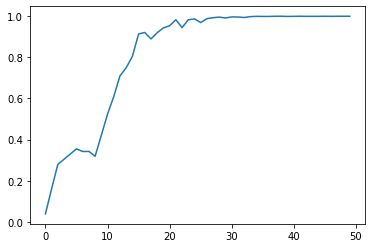

In [3]:
plt.plot(transformer_res['train_accs'])

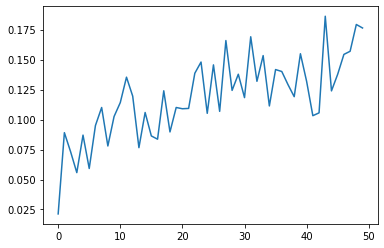

In [4]:
plt.plot(transformer_res['test_accs'])

In [5]:
with open('../results/language_parser/scan/addjump/addjump/train_defaults_jump0.json', 'r') as f:
    lp_res = json.load(f)

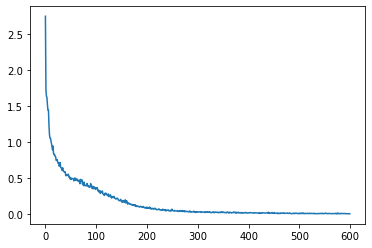

In [6]:
plt.plot(lp_res['loss_data'])

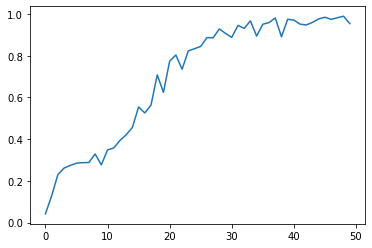

In [7]:
plt.plot(lp_res['train_accs'])

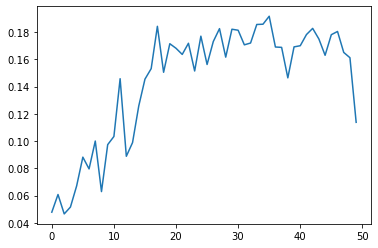

In [8]:
plt.plot(lp_res['test_accs'])

In [9]:
with open('../results/sep-transformer/scan/addjump/addjump/train_defaults_jump0.json', 'r') as f:
    st_res = json.load(f)

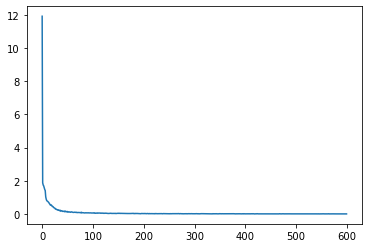

In [10]:
plt.plot(st_res['loss_data'])

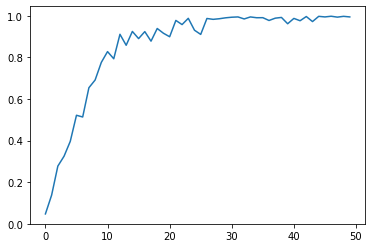

In [11]:
plt.plot(st_res['train_accs'])

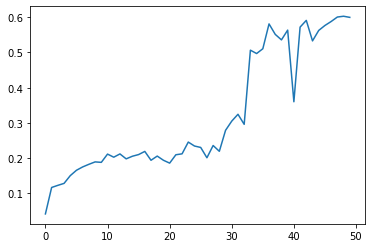

In [12]:
plt.plot(st_res['test_accs'])

In [13]:
from data import build_scan
import torch
import numpy as np
SRC, TRG, data, pos_data = build_scan(split='addjump', batch_size=64, device='cpu', use_pos=False)

In [14]:
src_txt = ['<sos> jump left <eos>', '<sos> walk left <eos>', '<sos> jump twice <eos>', '<sos> walk twice <eos>', '<sos> jump opposite left <eos>', '<sos> walk opposite left <eos>', '<sos> jump around left <eos>', '<sos> walk around left <eos>', '<sos> turn around right and jump around right twice <eos>', '<sos> turn around right and walk around right twice <eos>', '<sos> jump opposite right twice after jump left twice <eos>', '<sos> walk opposite right twice after walk left twice <eos>']

In [15]:
ss = []
for s in src_txt:
    ss.append(s.split())

In [16]:
# For now, will have to do it sequentially, in pairs of two
src = []
for s in src_txt:
    l = []
    count = 0
    for w in s.split():
        l.append(SRC.vocab.stoi[w])
        count += 1
    while count < 10:
        l.append(1)
        count += 1
    src.append(l)
src = torch.from_numpy(np.array(src, dtype=int))
src

tensor([[ 2, 16,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  5,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 10,  6,  3,  1,  1,  1,  1,  1,  1],
        [ 2, 16,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  9,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 16,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 10,  8,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 15,  8,  4, 14, 16,  8,  4,  6,  3],
        [ 2, 15,  8,  4, 14, 10,  8,  4,  6,  3],
        [ 2, 16,  9,  4,  6, 13, 16,  5,  6,  3],
        [ 2, 10,  9,  4,  6, 13, 10,  5,  6,  3]])

In [17]:
trg_txt = ['<sos> I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK <eos>', '<sos> I_JUMP I_JUMP <eos>', '<sos> I_WALK I_WALK <eos>', '<sos> I_TURN_LEFT I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_TURN_LEFT I_WALK <eos>', '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>', '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <eos>', '<sos> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <eos>', '<sos> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>', '<sos> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <eos>']

In [18]:
tt = []
for t in trg_txt:
    tt.append(t.split())

In [19]:
# For now, will have to do it sequentially, in pairs of two
trg = []
for s in trg_txt:
    l = []
    count = 0
    for w in s.split():
        l.append(TRG.vocab.stoi[w])
        count += 1
    while count < 23:
        l.append(1)
        count += 1
    trg.append(l)
trg = torch.from_numpy(np.array(trg, dtype=int))
trg

tensor([[2, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 9, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 6, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 9, 5, 9, 5, 9, 5, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 5, 6, 5, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 4, 4, 4, 4, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 4, 9, 3, 1],
        [2, 4, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 3, 1],
        [2, 5, 9, 5, 9, 4, 4, 9, 4, 4, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 5, 6, 5, 6, 4, 4, 6, 4, 4, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [20]:
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

Transformer Attention Visualizations

In [57]:
import torch
from models.models import Transformer
model = Transformer(
    src_vocab_size=17,
    trg_vocab_size=10,
    d_model=256,
    nhead=8,
    n_layers=2,
    dim_feedforward=512,
    dropout=0.1,
    pad_idx=1,
    device=torch.device('cpu')
)
device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/transformer/scan/defaults_addjump.pt', map_location=device))
model.device = 'cpu'

In [58]:
model.eval()
with torch.no_grad():
    trg_input = trg[:, :-1]
    out, attn_wt = model(src, trg_input)
    pred = torch.argmax(out, axis=2)

In [59]:
predictions = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())

Encoder Layer 1


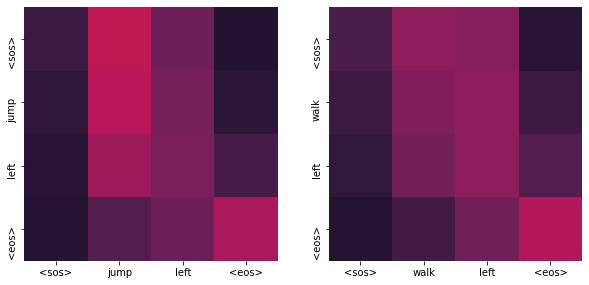

Encoder Layer 2


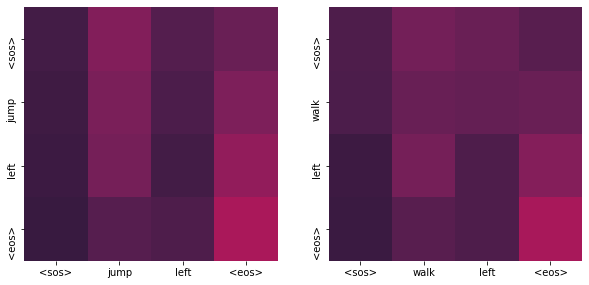

In [60]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i])
    plt.show()

Decoder Self Attention Layer 1


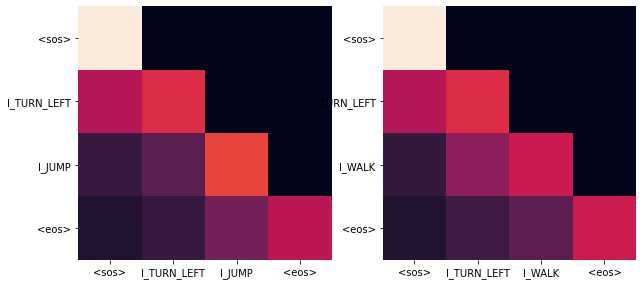

Decoder Self Attention Layer 2


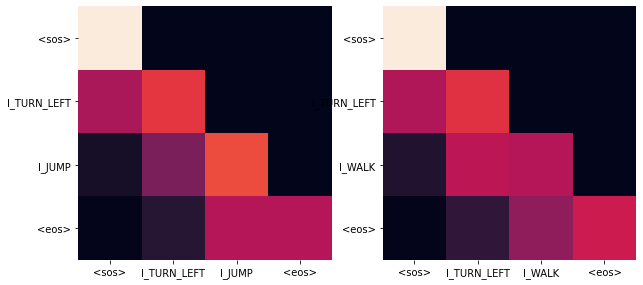

In [61]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i])
    plt.show()

Decoder MHA Layer 1


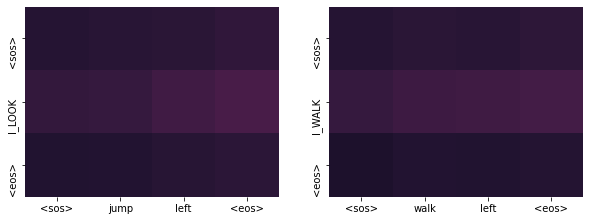

Decoder MHA Layer 2


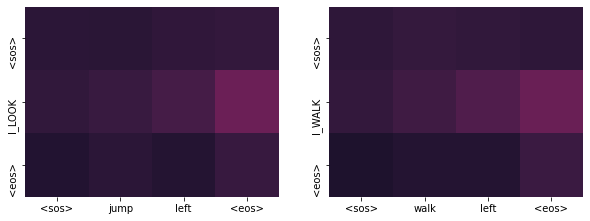

In [62]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(2):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(predictions[i]), :len(ss[i])],
             ss[i], predictions[i], ax=axs[i])
    plt.show()

Encoder Layer 1


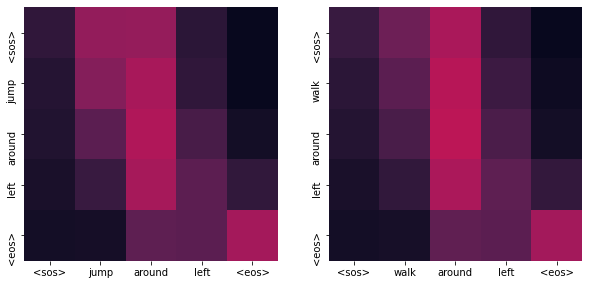

Encoder Layer 2


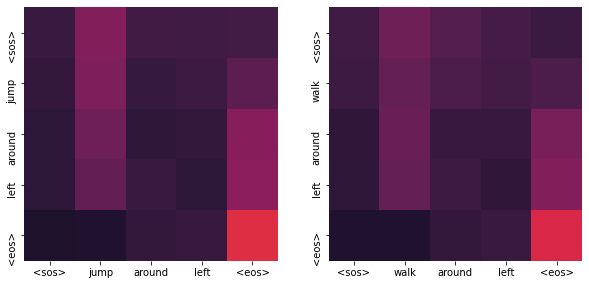

In [63]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i-6])
    plt.show()

Decoder Self Attention Layer 1


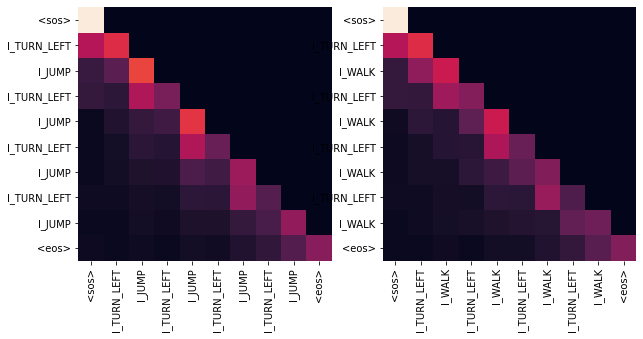

Decoder Self Attention Layer 2


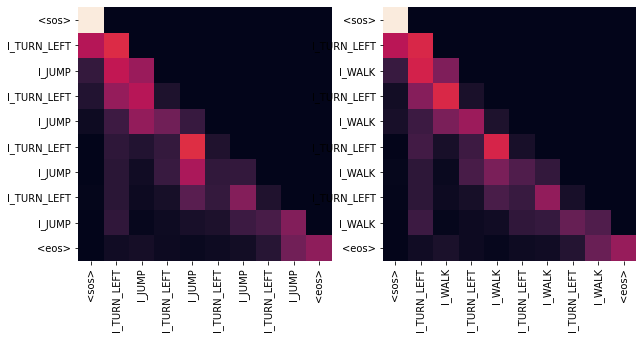

In [64]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i-6])
    plt.show()

Decoder MHA Layer 1


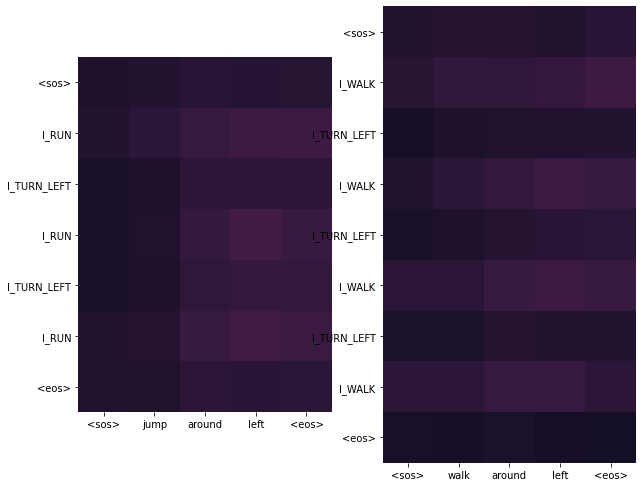

Decoder MHA Layer 2


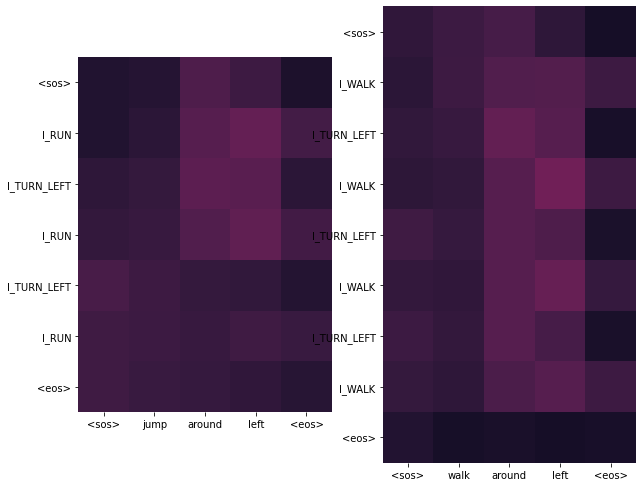

In [65]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(6, 8):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(predictions[i]), :len(ss[i])],
             ss[i], predictions[i], ax=axs[i-6])
    plt.show()

Encoder Layer 1


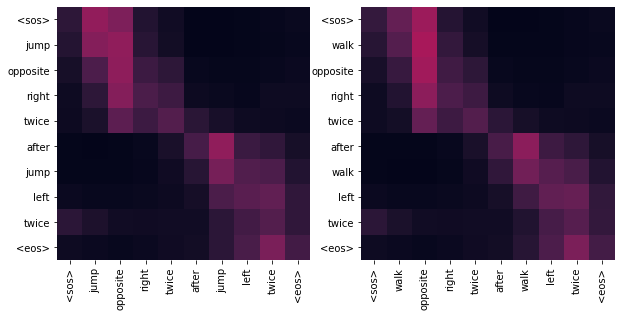

Encoder Layer 2


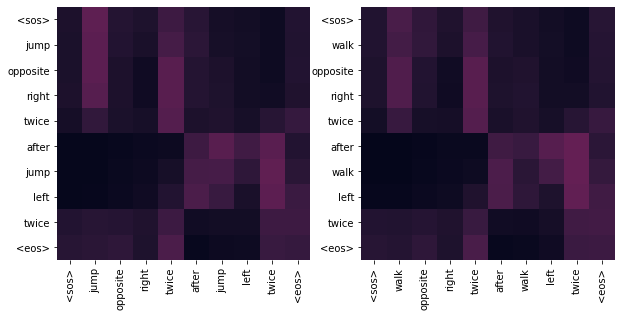

In [66]:
for layer in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Encoder Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Encoder')[layer][i][:len(ss[i]), :len(ss[i])], ss[i], ss[i], ax=axs[i-10])
    plt.show()

Decoder Self Attention Layer 1


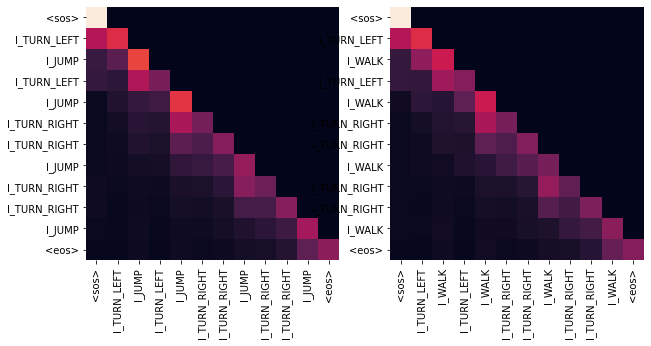

Decoder Self Attention Layer 2


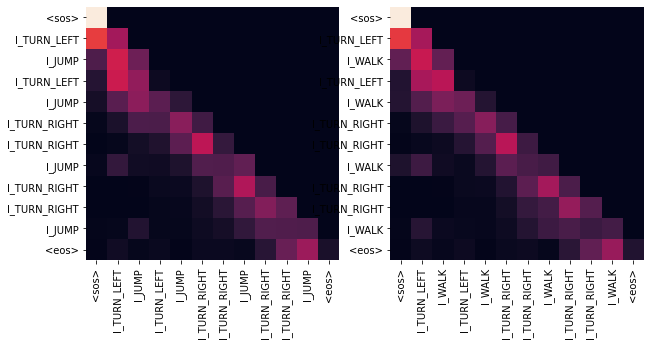

In [67]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer1')[i][:len(tt[i]), :len(tt[i])], 
             tt[i], tt[i], ax=axs[i-10])
    plt.show()

Decoder MHA Layer 1


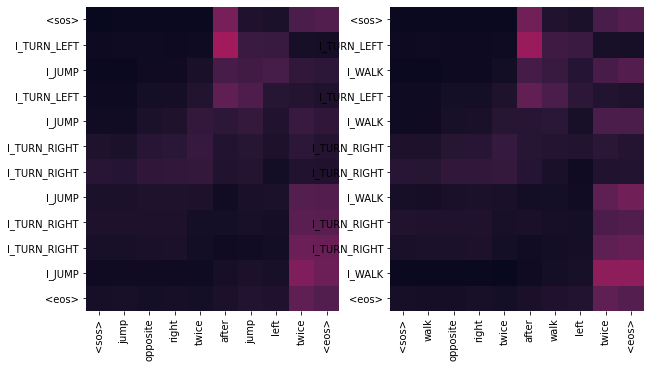

Decoder MHA Layer 2


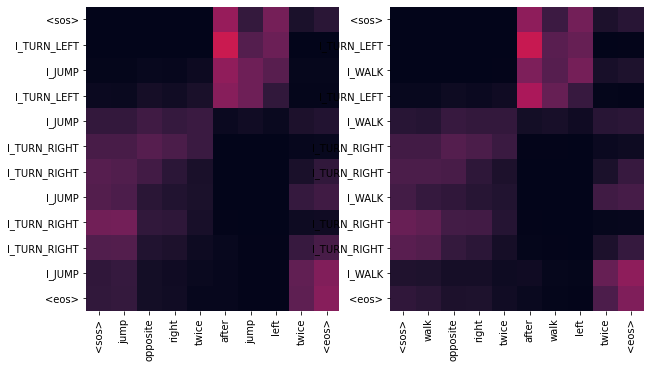

In [68]:
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Decoder MHA Layer {layer + 1}")
    for i in range(10, 12):
        draw(attn_wt.get('Decoder')[layer].get('Sublayer2')[i][:len(tt[i]), :len(ss[i])],
             ss[i], tt[i], ax=axs[i-10])
    plt.show()

In [69]:
import torch
from models.models import LanguageParser
model = LanguageParser(
    src_vocab_size=17,
    trg_vocab_size=10,
    d_model=128,
    nhead=8,
    n_layers=1,
    dim_feedforward=128,
    dropout=0.1,
    pad_idx=1,
    device=torch.device('cpu')
)
device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/language_parser/scan/defaults_addjump.pt', map_location=device))
model.device = 'cpu'

In [70]:
model.eval()
with torch.no_grad():
    trg_input = trg[:, :-1]
    out, attn_wt = model(src, trg_input)
    pred = torch.argmax(out, axis=2)

In [71]:
predictions = []
for s in pred:
    prediction = '<sos> '
    for i in range(1, s.shape[0]):
        sym = TRG.vocab.itos[s[i]]
        if sym == '<eos>': break
        prediction += sym + ' '
    prediction += '<eos>'
    predictions.append(prediction.split())

Stage 0, Block Encoder Attention Map


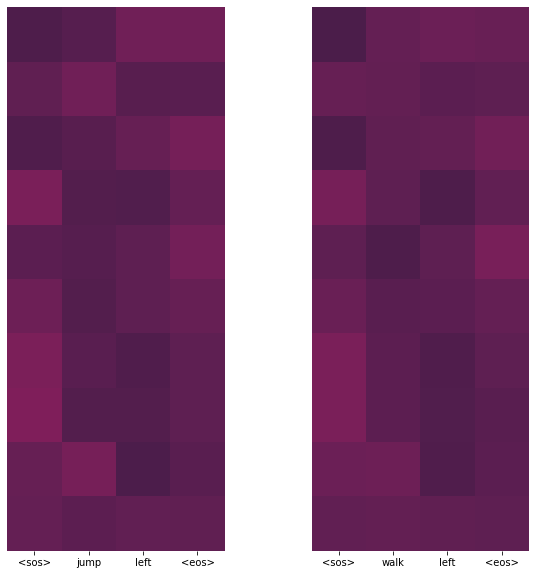

Stage 1, Block Encoder Attention Map


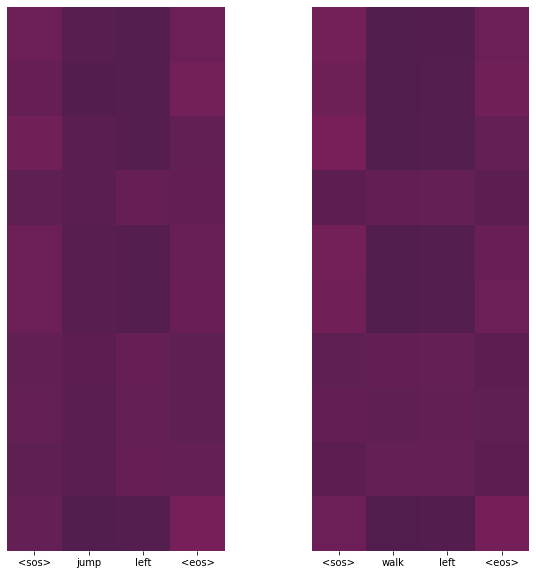

In [51]:
enc_maps = attn_wt.get('Encoder')
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Encoder Attention Map")
    for i in range(2, 4):
        draw(torch.mean(enc_maps[s][0].get('encoder'), axis=2)[i][:, :len(ss[i])], ss[i], [], ax=axs[i-2])
    plt.show()

Stage 0, Block Decoder MHA


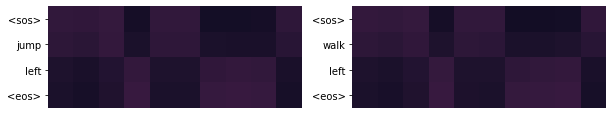

Stage 1, Block Decoder MHA


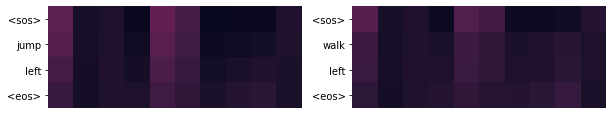

In [52]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Decoder MHA")
    for i in range(2):
        draw(torch.mean(enc_maps[s][0].get('decoder').get('MHA'), axis=2)[i][:len(ss[i]), :], [], ss[i], ax=axs[i])
    plt.show()

Stage 0, Block Decoder Self


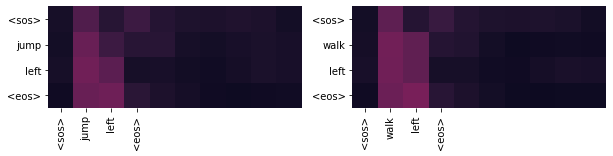

Stage 1, Block Decoder Self


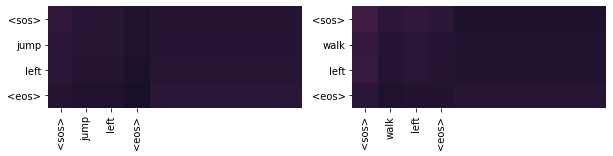

In [53]:
for s in range(0, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    print(f"Stage {s}, Block Decoder Self")
    for i in range(2):
        draw(torch.mean(enc_maps[s][0].get('decoder').get('Self'), axis=2)[i][:len(ss[i]), :], ss[i], ss[i], ax=axs[i])
    plt.show()

Last Encoder Map


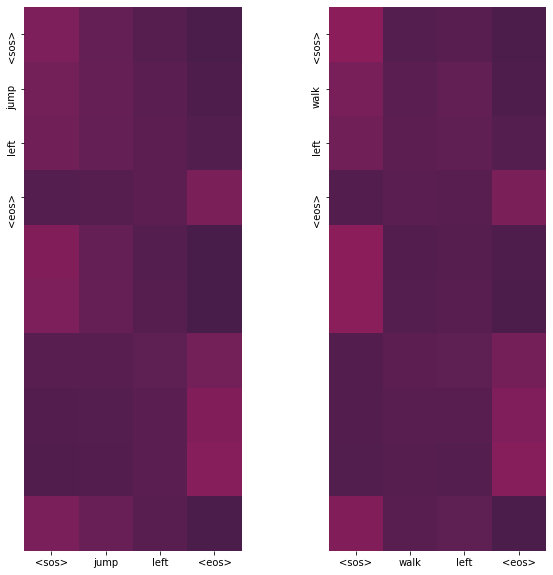

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
print(f"Last Encoder Map")
for i in range(2):
    draw(torch.mean(enc_maps[1][1], axis=2)[i][:, :len(ss[i])], ss[i], ss[i], ax=axs[i])

Decoder Self Attention Layer 1


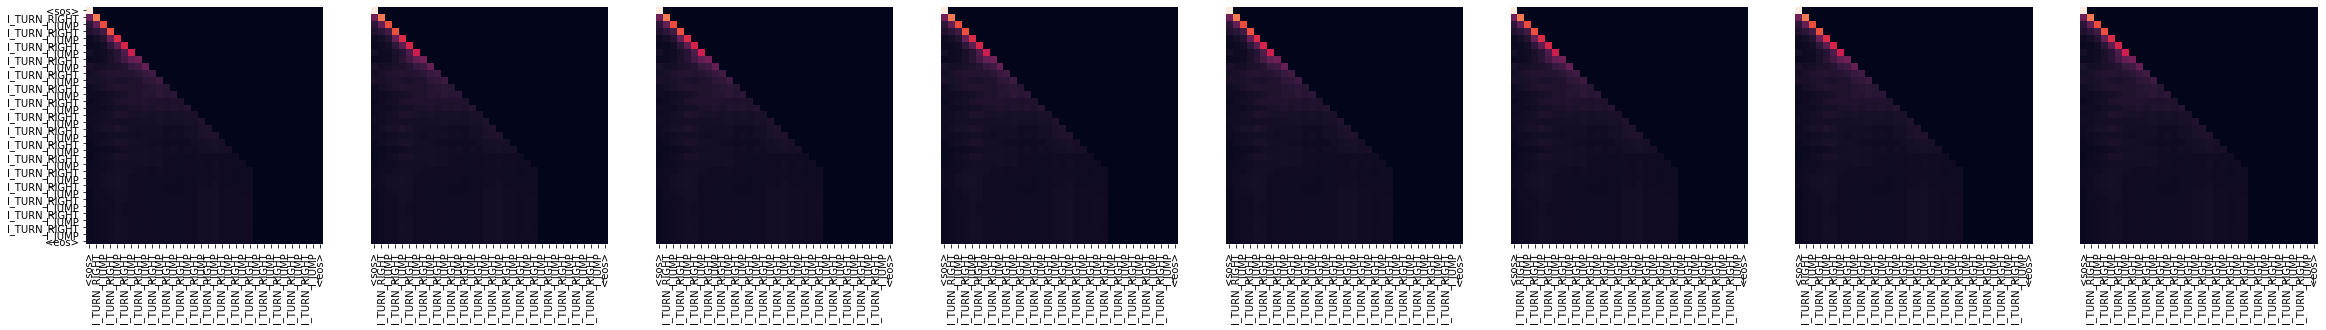

Decoder Self Attention Layer 2


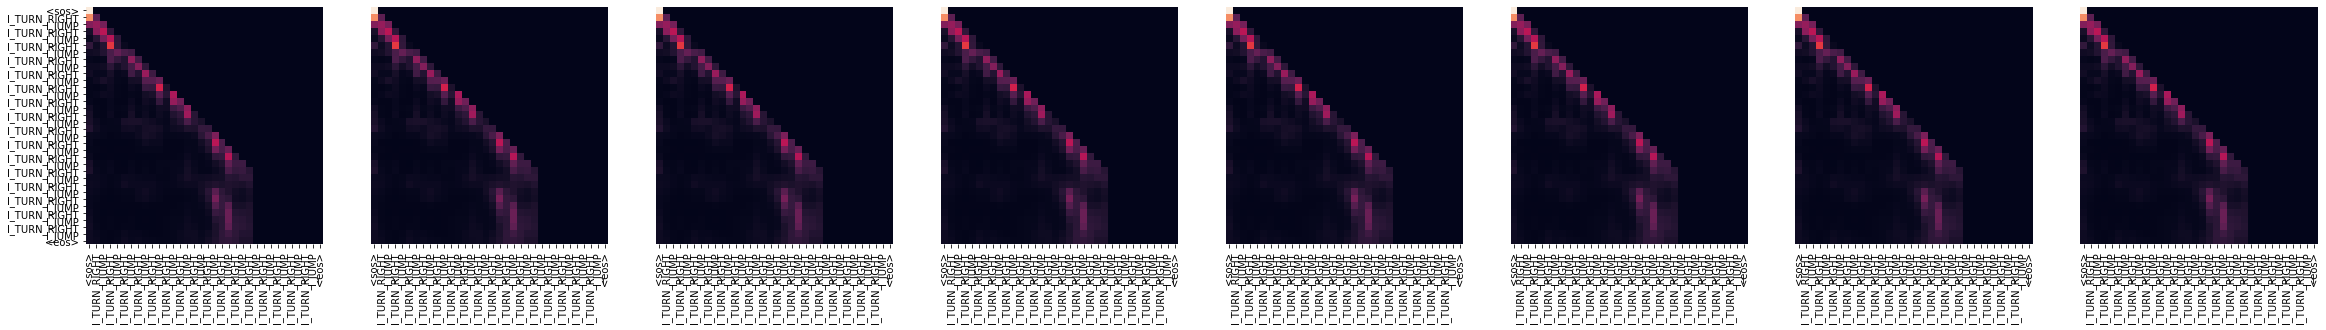

Decoder Self Attention Layer 3


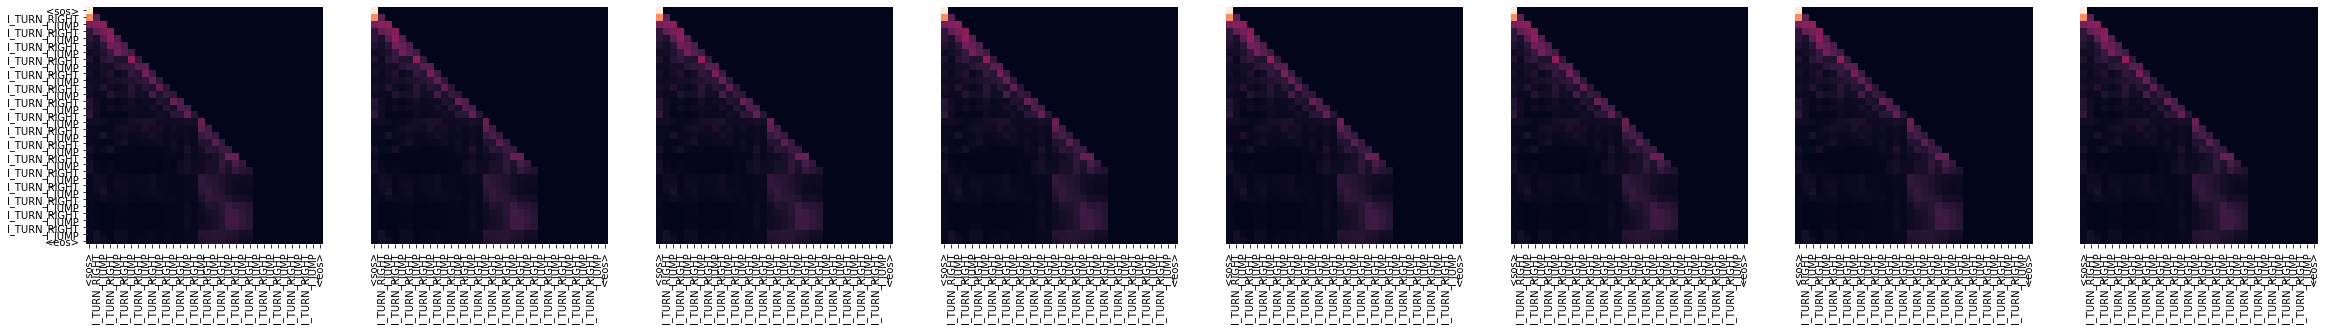

Decoder Self Attention Layer 4


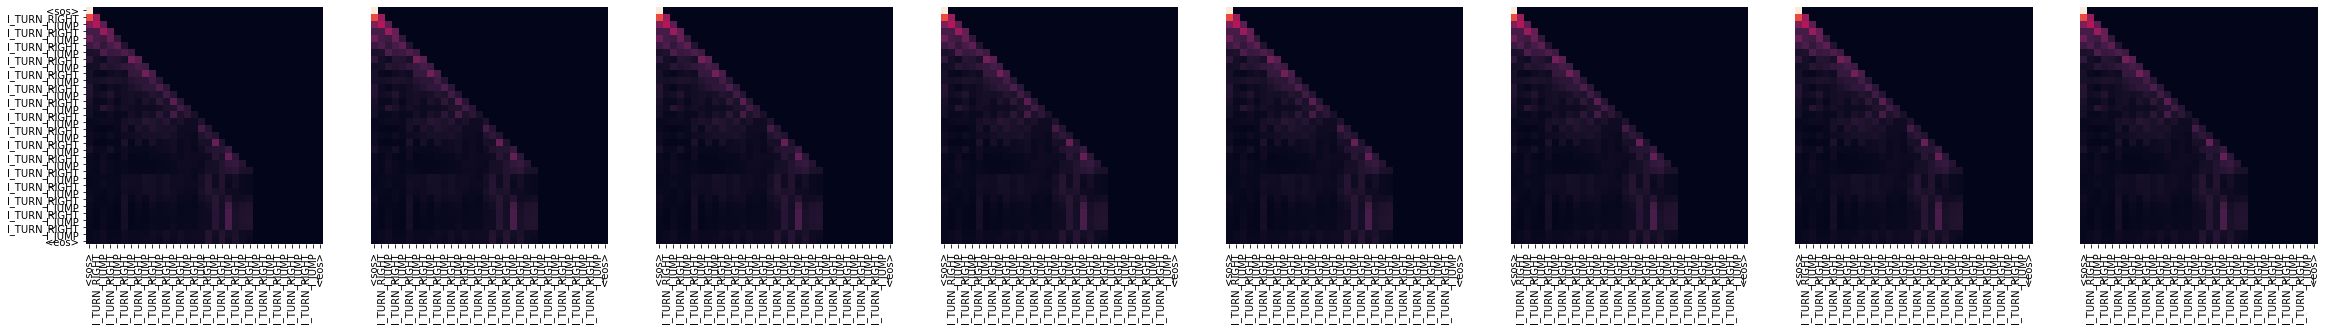

In [10]:
for layer in range(0, 4, 1):
    fig, axs = plt.subplots(1, 8, figsize=(40, 40))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for h in range(8):
        draw(attn_wts[-1].get('Decoder')[layer].get('Sublayer1')[2][:len(tt), :len(tt)], 
             tt, tt if h == 0 else [], ax=axs[h])
    plt.show()

Decoder MHA Layer 1


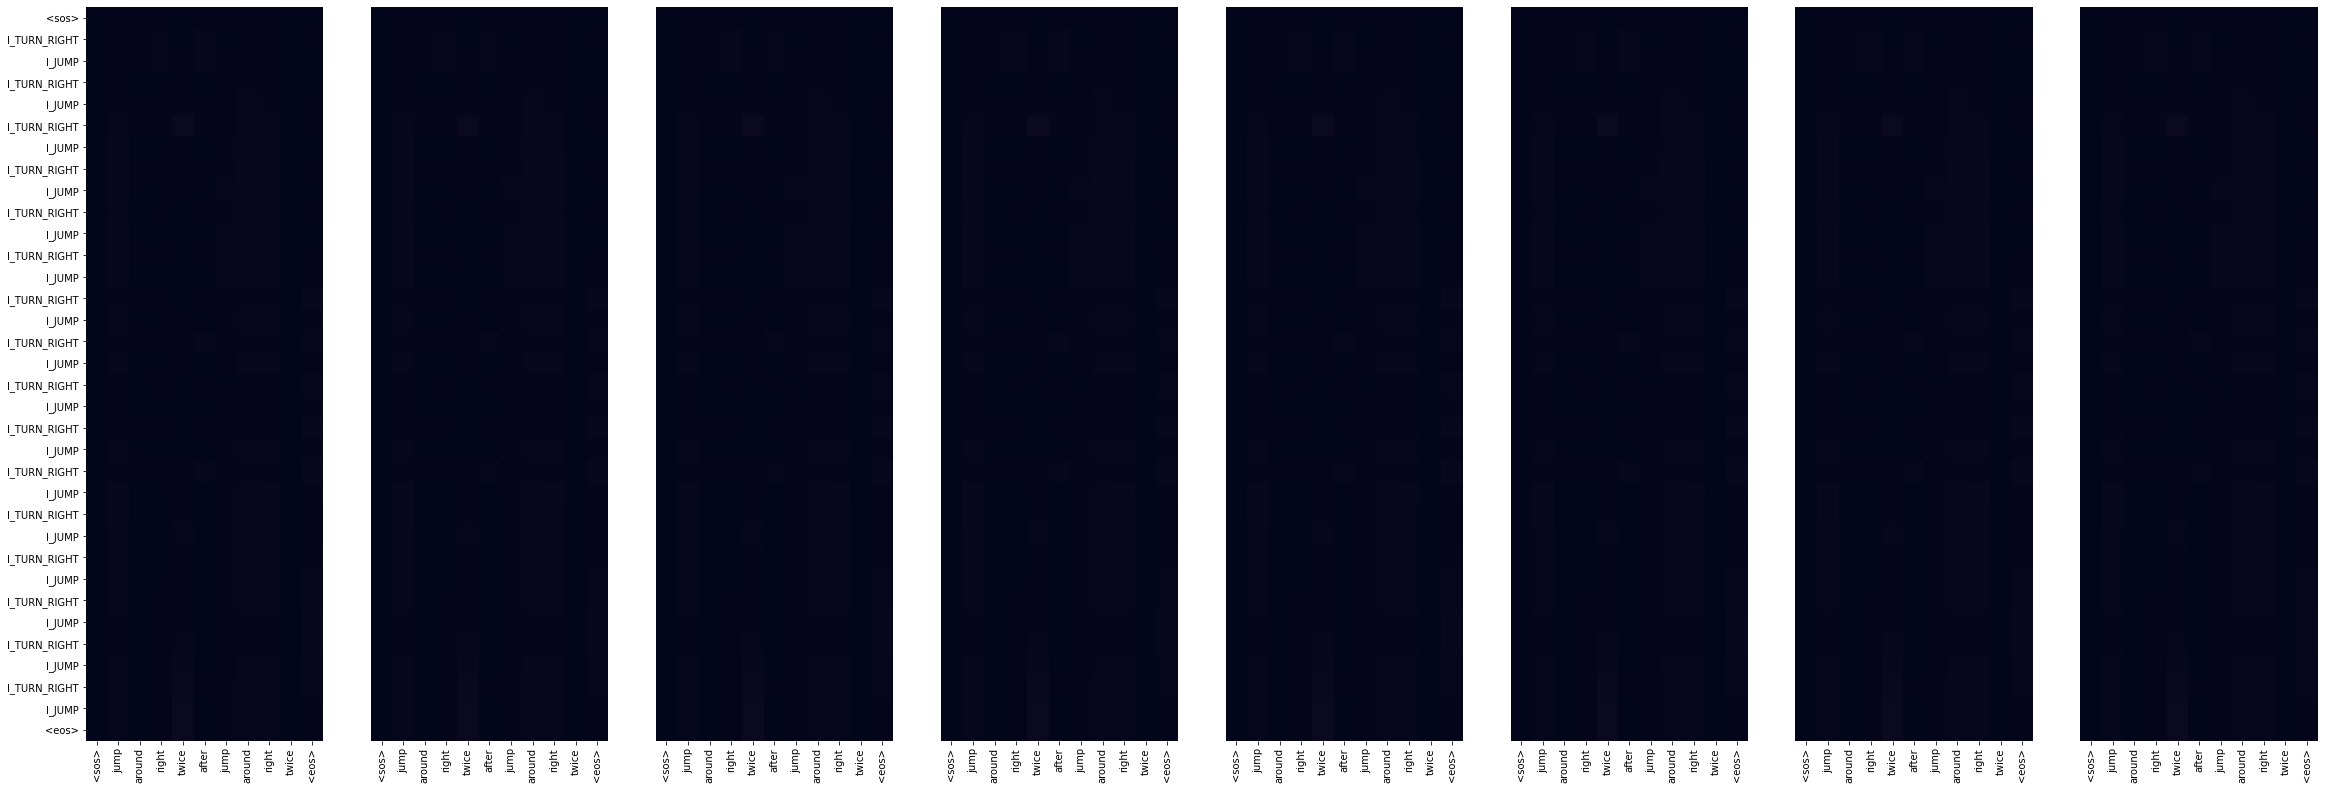

Decoder MHA Layer 2


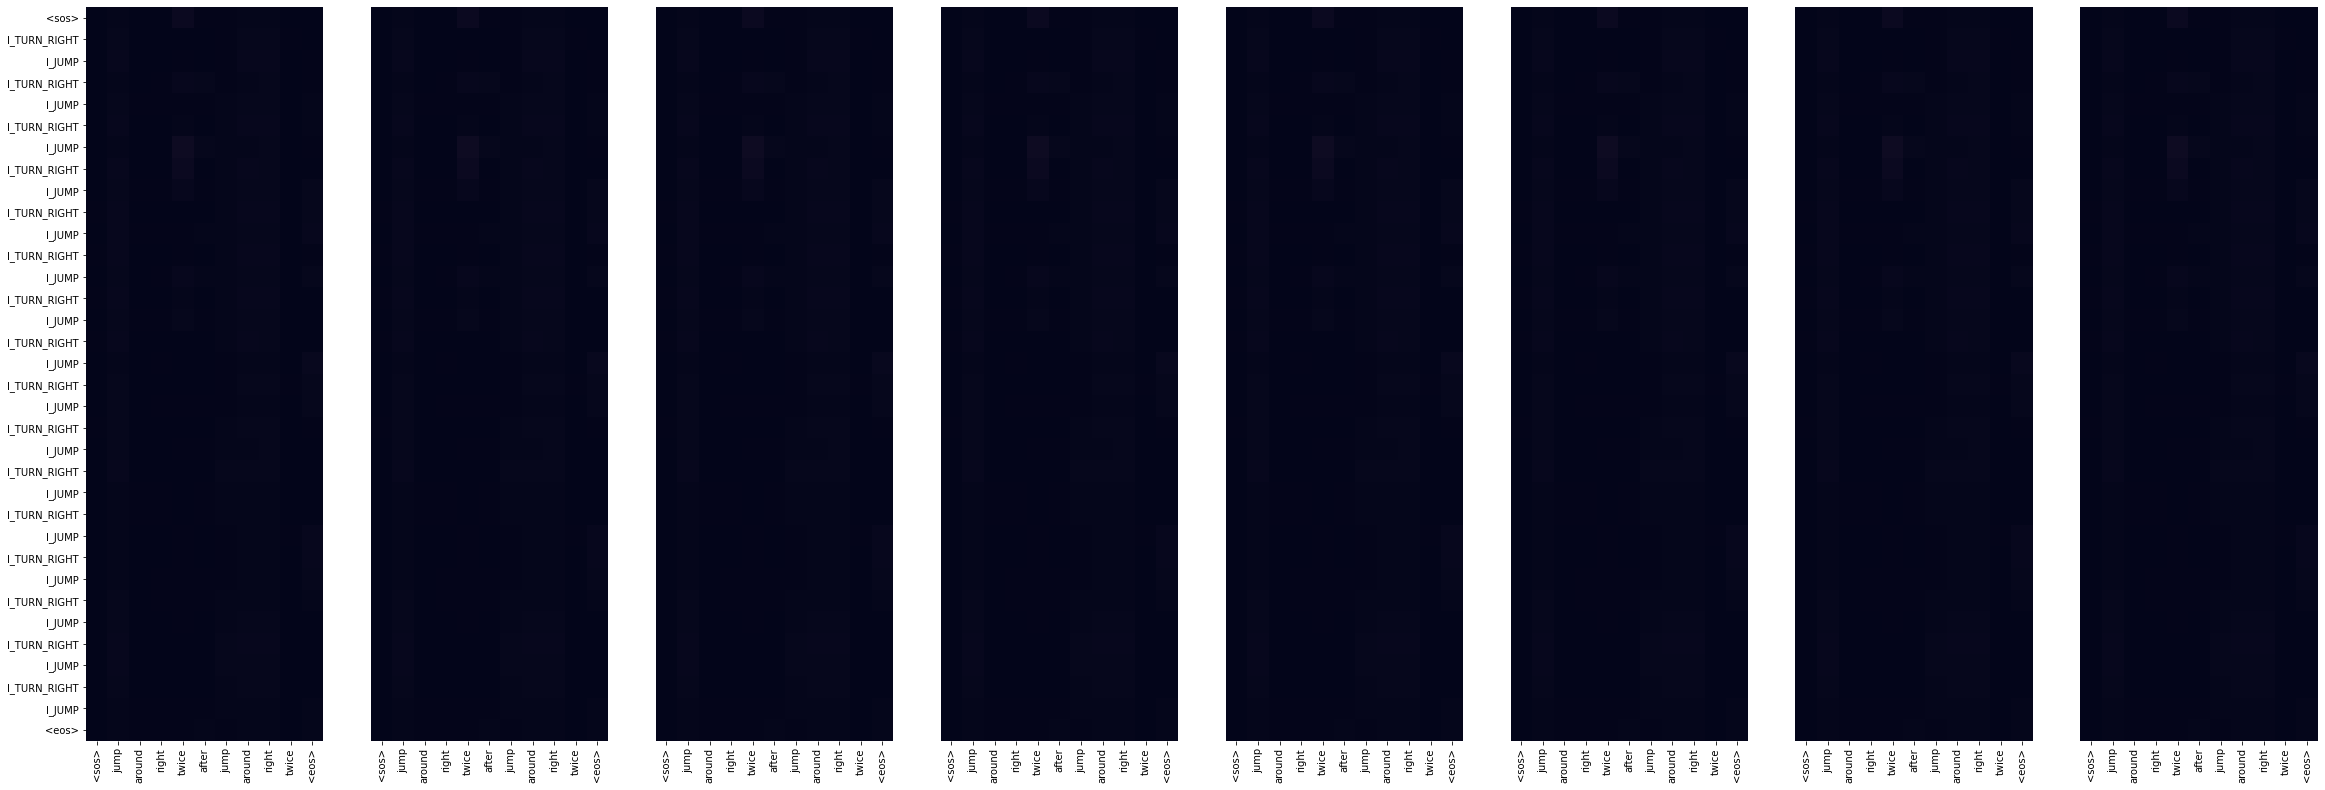

Decoder MHA Layer 3


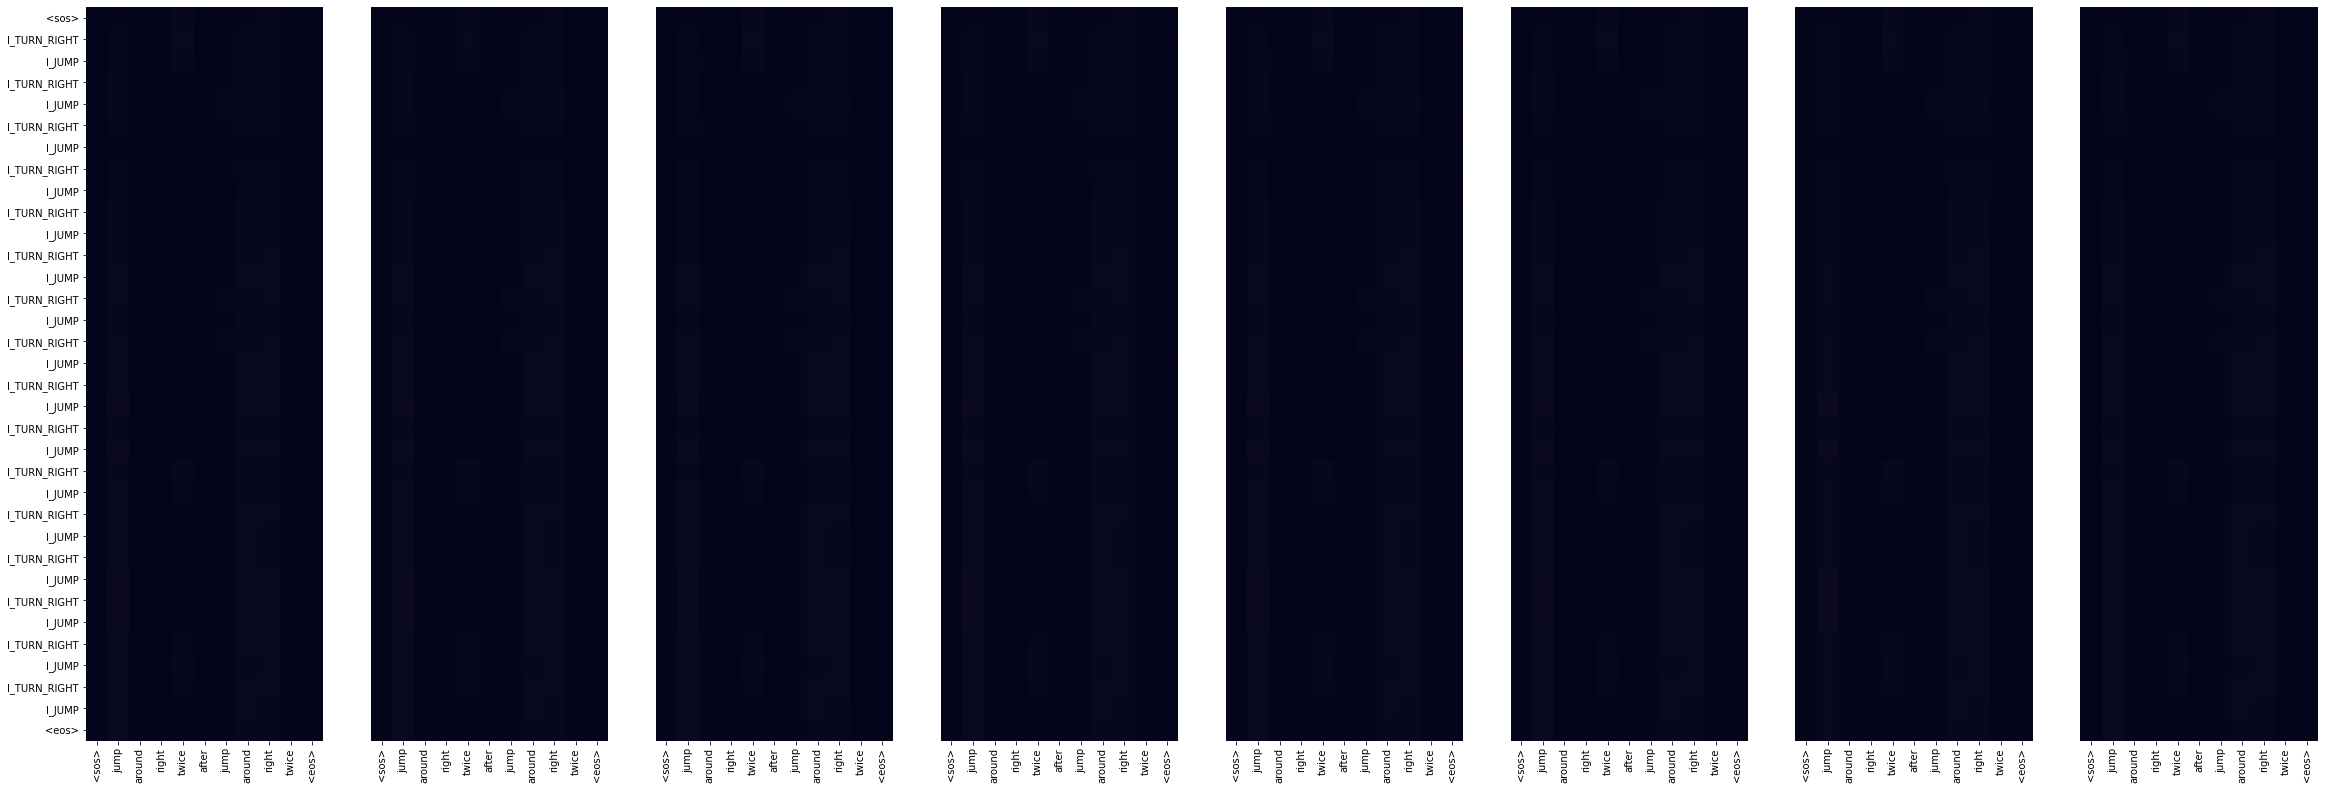

Decoder MHA Layer 4


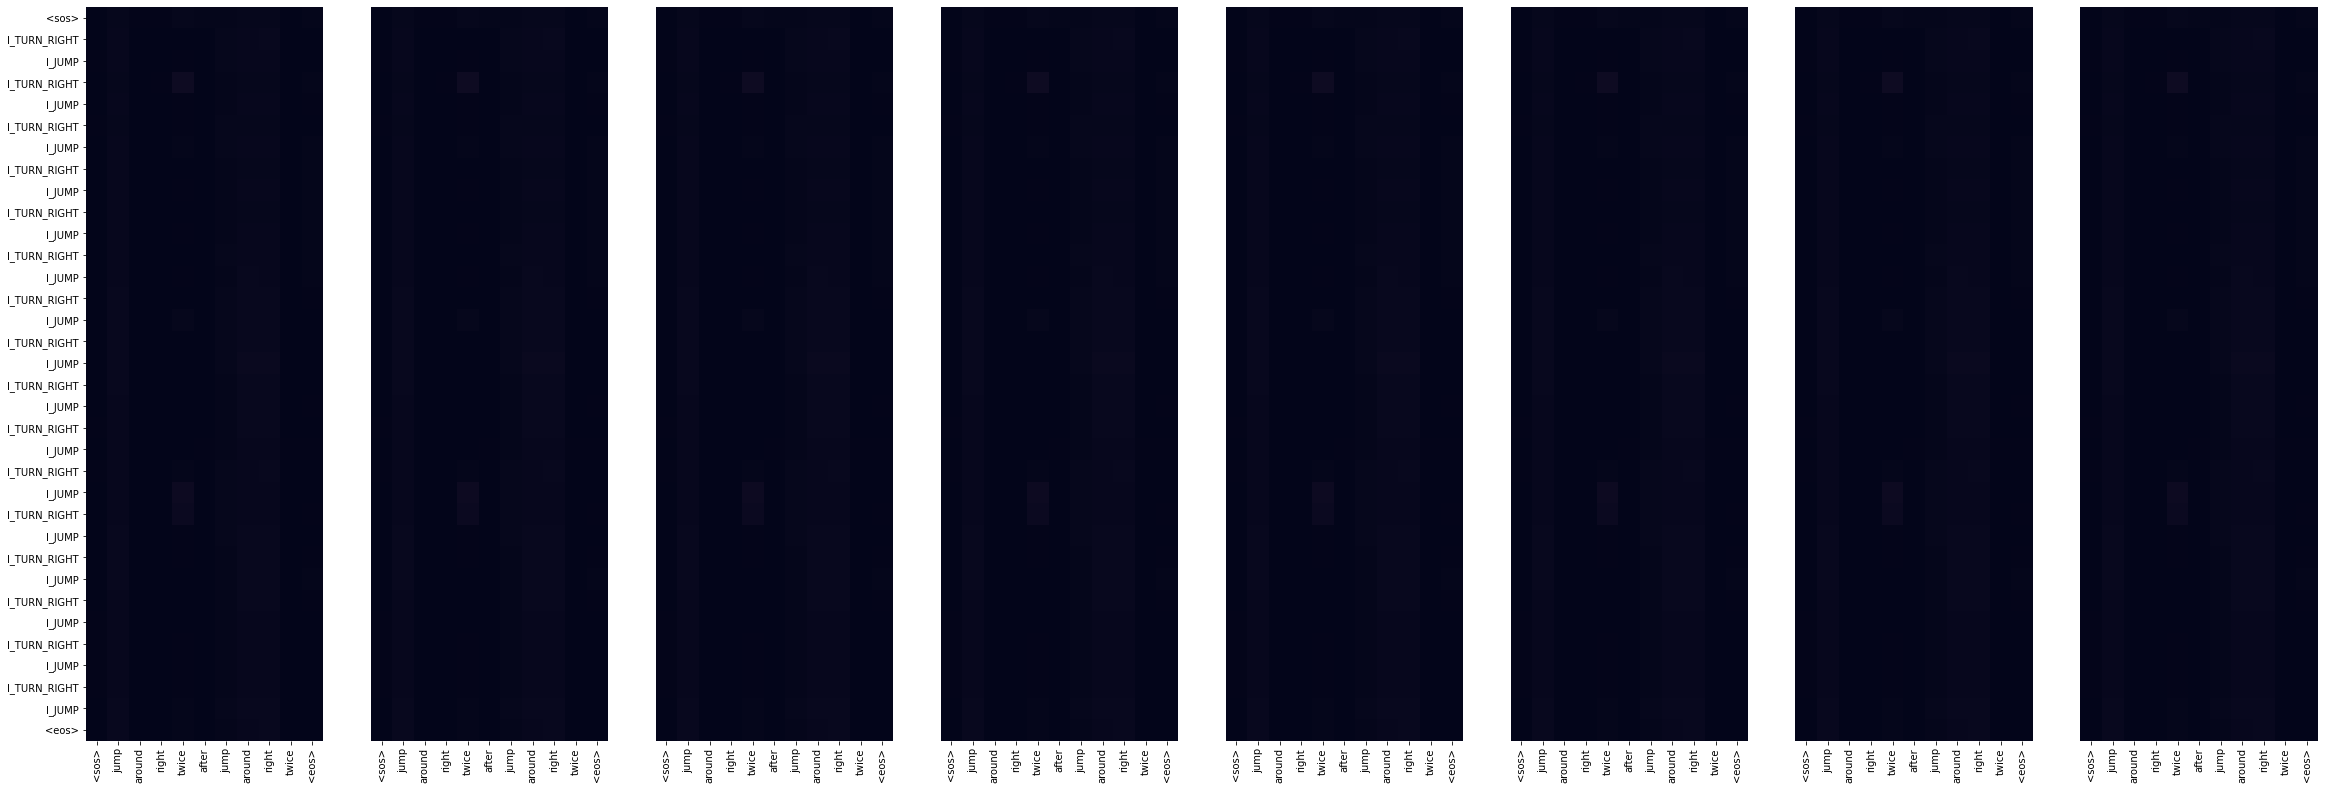

In [11]:
for layer in range(0, 4, 1):
    fig, axs = plt.subplots(1, 8, figsize=(40, 40))
    print(f"Decoder MHA Layer {layer + 1}")
    for h in range(8):
        draw(attn_wts[-1].get('Decoder')[layer].get('Sublayer2')[2][:len(tt), :len(ss)],
             ss, tt if h == 0 else [], ax=axs[h])
    plt.show()

Sep Transformer Analysis


In [129]:
SRC, TRG, data, pos_data = build_scan(split='addjump', batch_size=64, device='cpu', use_pos=True)

In [132]:
import torch
from models.tp_separate import EmbeddingMultilinearSinusoidal, Encoder, Decoder, Seq2Seq

embedding = EmbeddingMultilinearSinusoidal(d_vocab=18,
                                           d_x=256,
                                           d_r=256//8,
                                           dropout=0.1,
                                           max_length=200)
encoder = Encoder(
    d_x=256,
    d_q=256//8,
    d_k=256//8,
    d_v=256//8,
    d_f=512,
    n_I=8,
    n_L=2,
    use_xv=False,
    dropout=0.1
)
decoder = Decoder(
    d_x=256,
    d_q=256//8,
    d_k=256//8,
    d_v=256//8,
    d_f=512,
    use_xv=False,
    cat_xm=False,
    n_I=8,
    n_L=2,
    dropout=0.1
)

model = Seq2Seq(embedding=embedding,
               encoder=encoder,
               decoder=decoder,
               pad_idx=1,
               use_adversary=False,
               d_x=256,
               d_vocab=18,
               adv_lambda=0.01,
               adv_theta=0.01,
               adv_lr=0.01)

device = torch.device('cpu')
model.load_state_dict(torch.load('../weights/sep-transformer/scan/defaults_addjump.pt', map_location=device))
model = model.to(device)

In [14]:
model.eval()
with torch.no_grad():
    for ((i, batch), (i_p, batch_pos)) in zip(enumerate(test_data), enumerate(test_data_pos)):
       # transpose src and trg
        src = batch.src.transpose(0, 1)
        trg = batch.trg.transpose(0, 1)
        src_ann = batch_pos.src.transpose(0, 1)
        trg_ann = batch_pos.trg.transpose(0, 1)

        # augment trg
        trg_input = trg[:, :-1]
        trg_ann_input = trg_ann[:, :-1]
        trg_out = trg[:, 1:]
        trg_ann_out = trg_ann[:, 1:]

        out, adv_stat, attn_wts = model(src, trg_input, src_ann, trg_ann_input)
        
        pred = torch.argmax(out, axis=2)
        preds.append(pred)

Encoder Layer 1


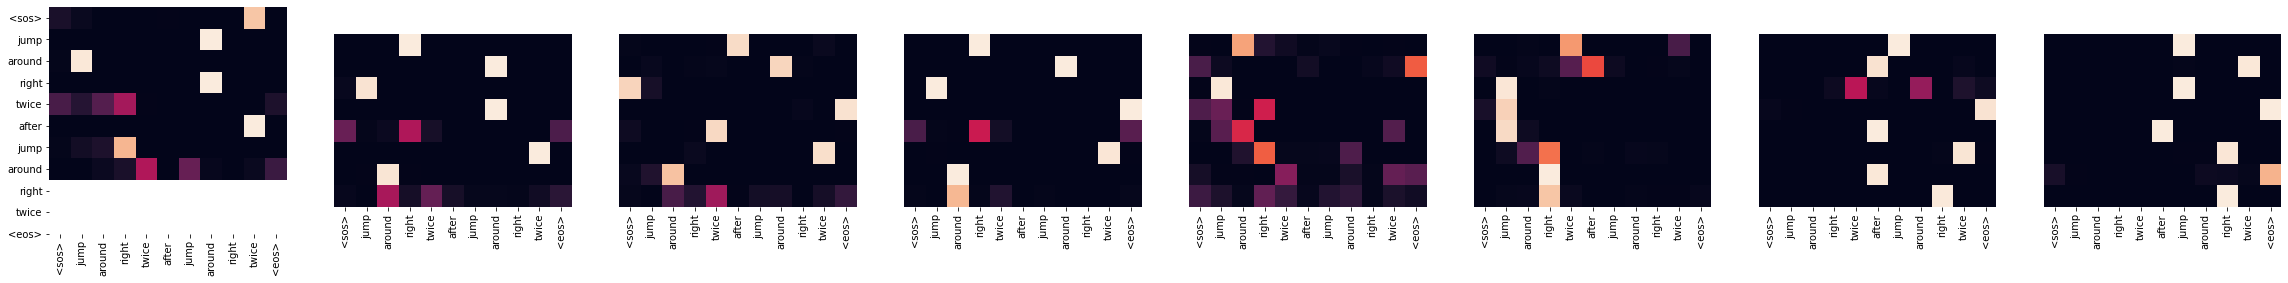

Encoder Layer 2


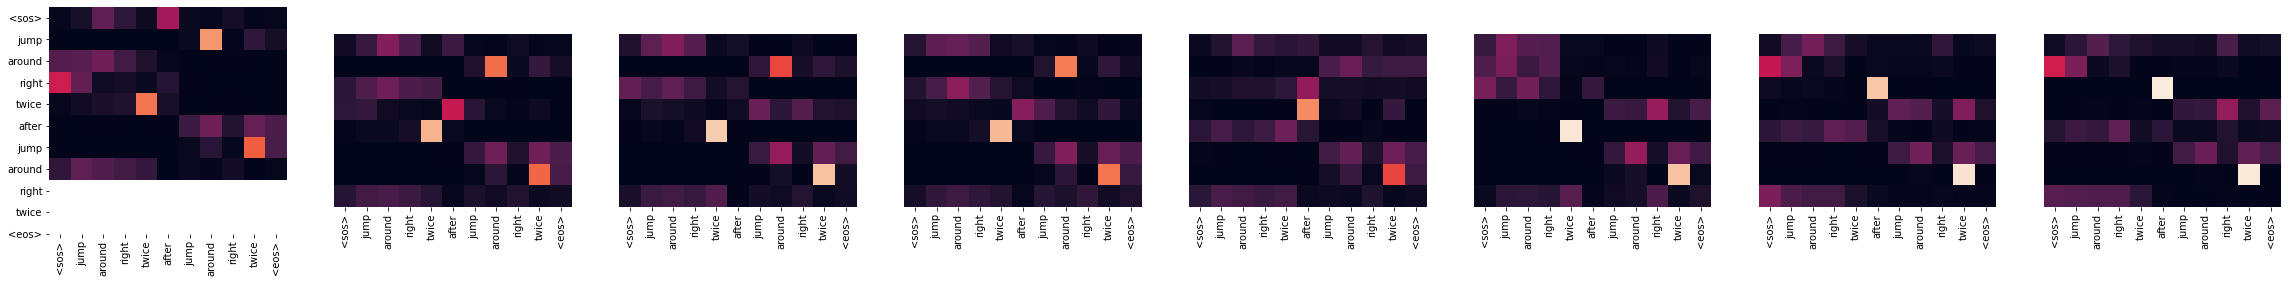

Encoder Layer 3


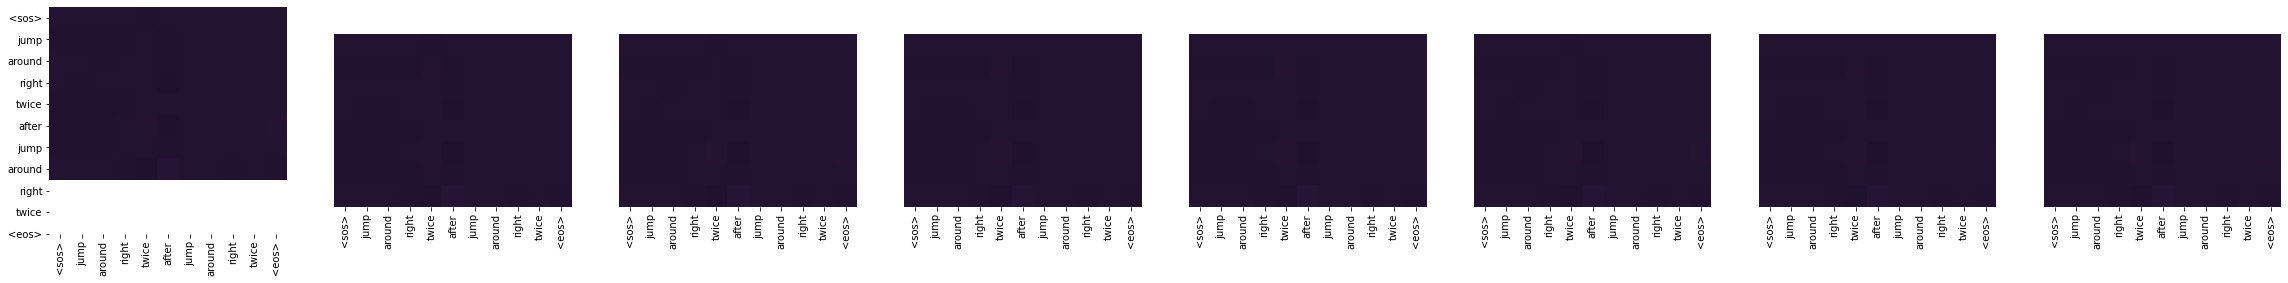

Encoder Layer 4


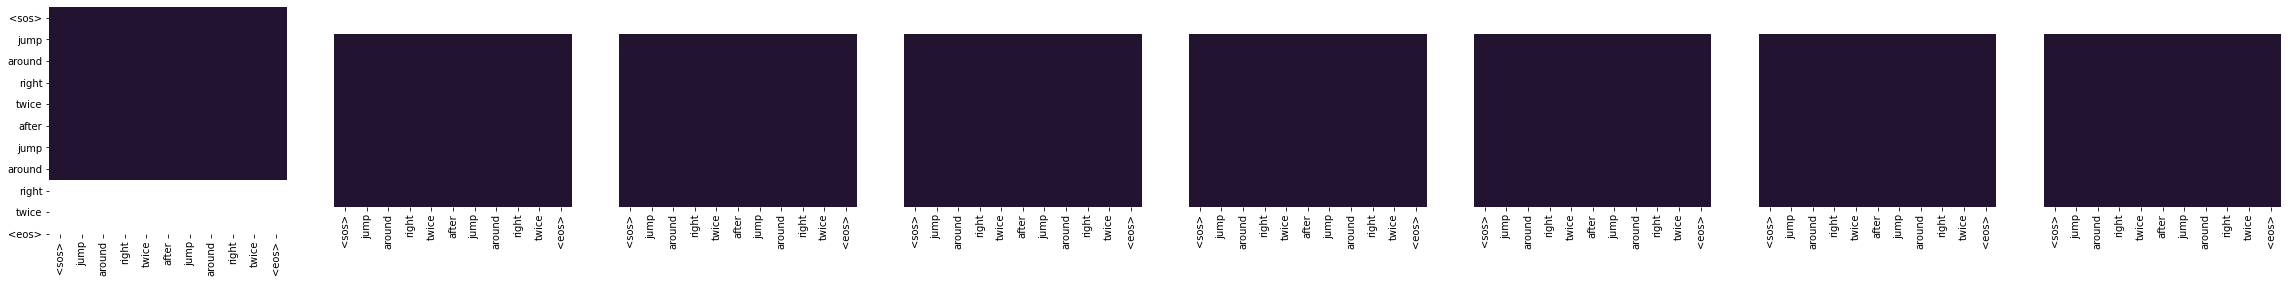

Encoder Layer 5


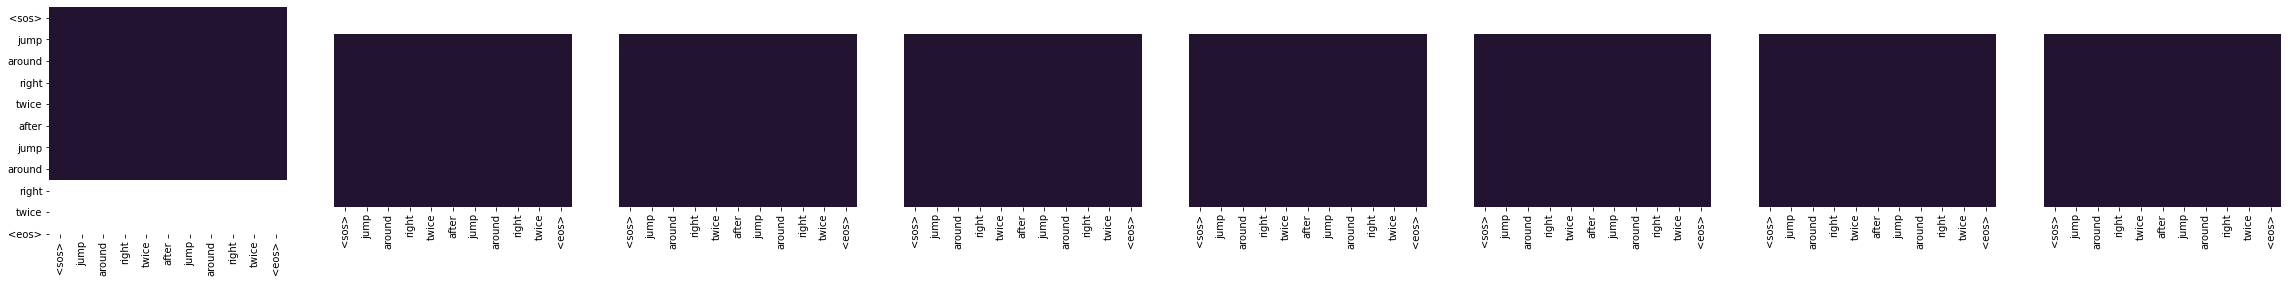

Encoder Layer 6


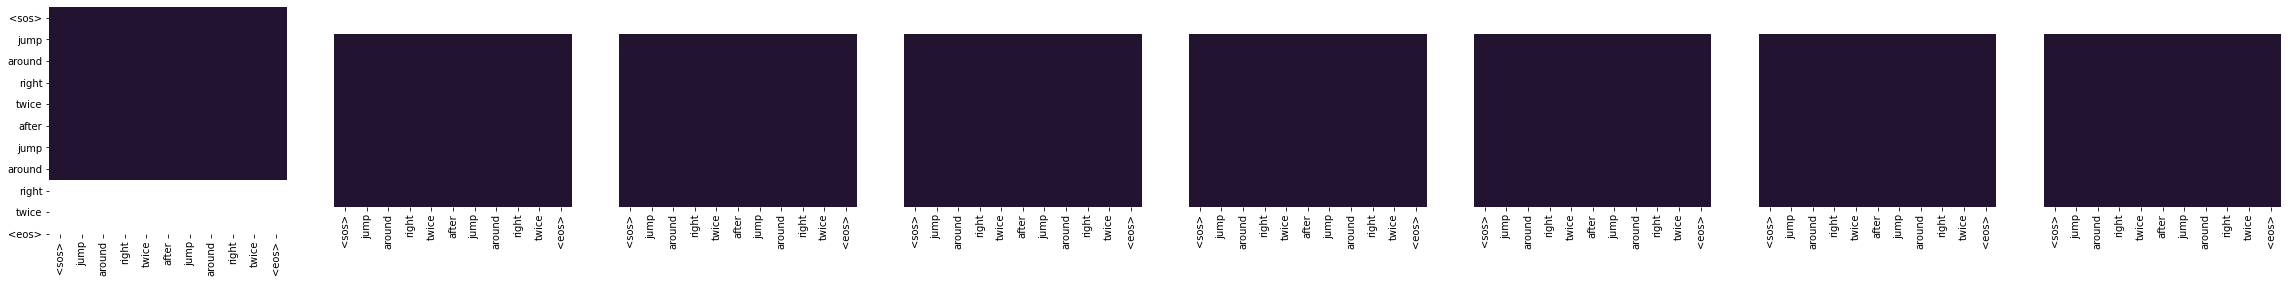

In [26]:
for layer in range(0, 6):
    fig, axs = plt.subplots(1, 8, figsize=(40, 40))
    print(f"Encoder Layer {layer + 1}")
    for h in range(8):
        draw(attn_wts.get('Encoder')[layer][2][:, h, :][:len(ss), :len(ss)], ss, ss if h == 0 else [], ax=axs[h])
    plt.show()

Decoder Self Attention Layer 1


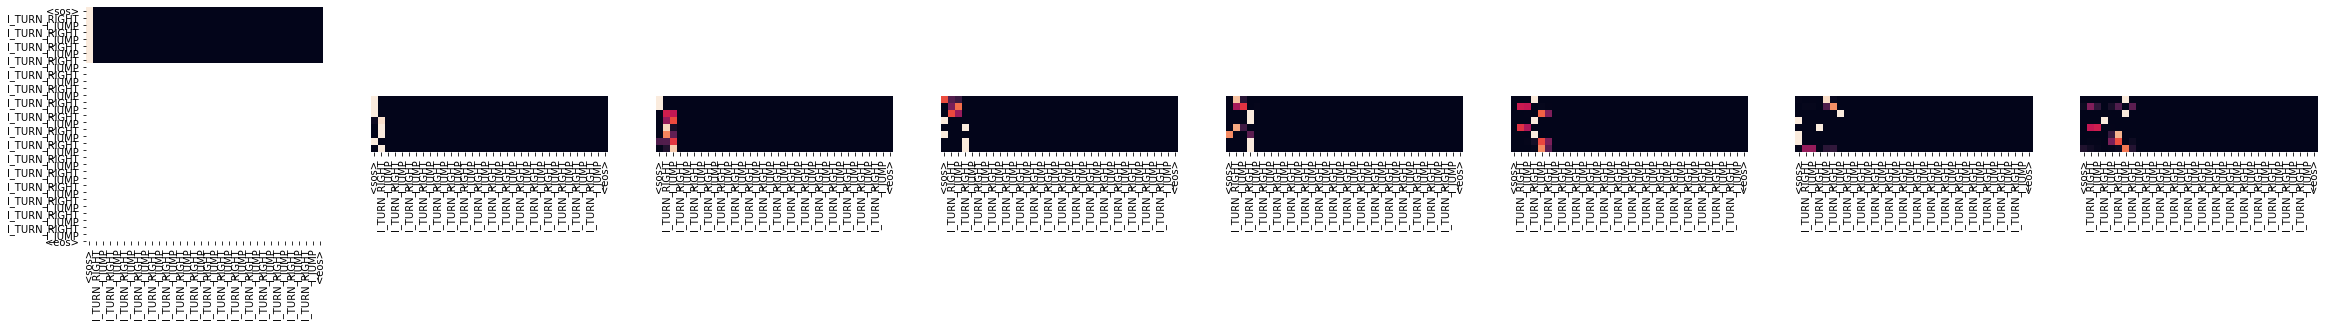

Decoder Self Attention Layer 2


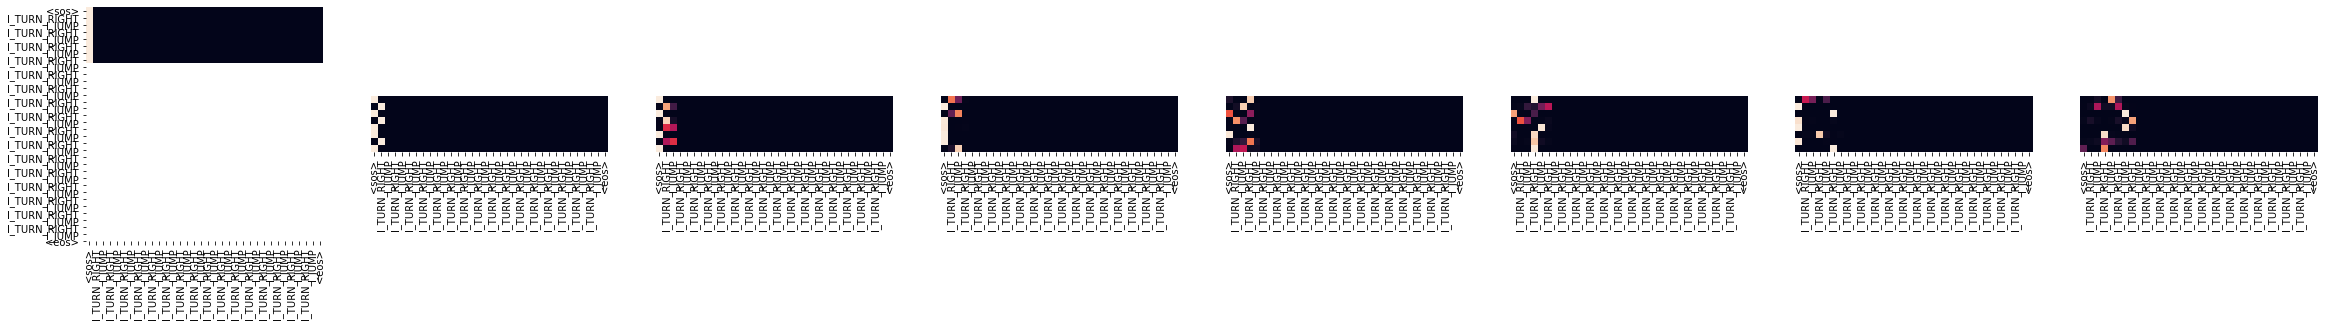

Decoder Self Attention Layer 3


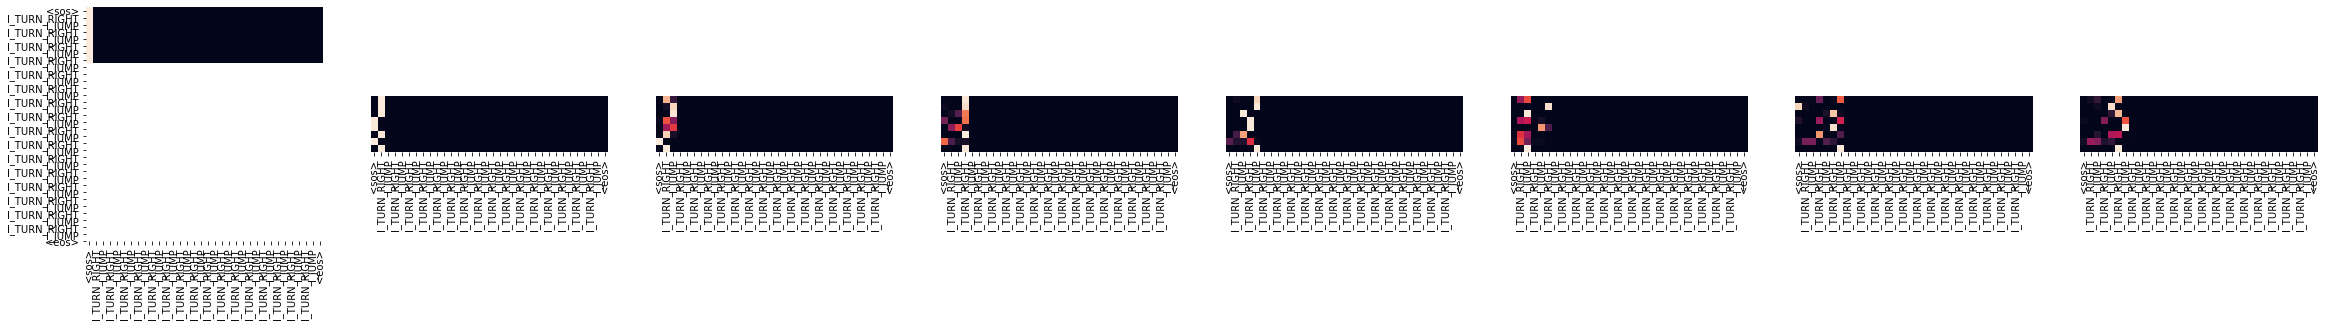

Decoder Self Attention Layer 4


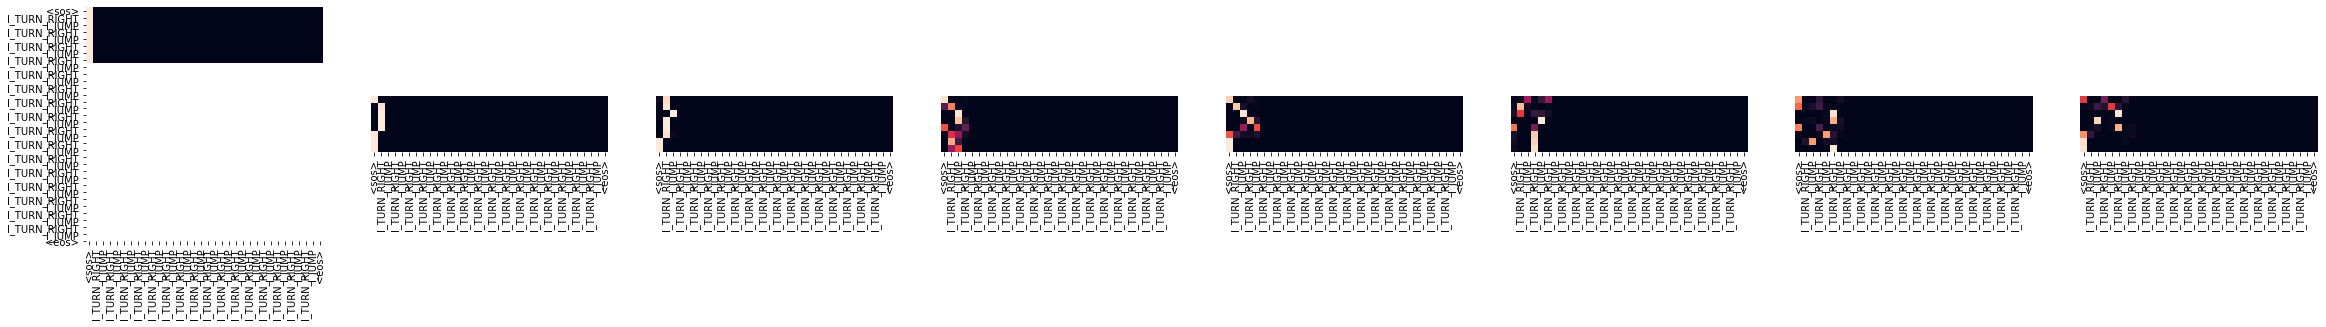

Decoder Self Attention Layer 5


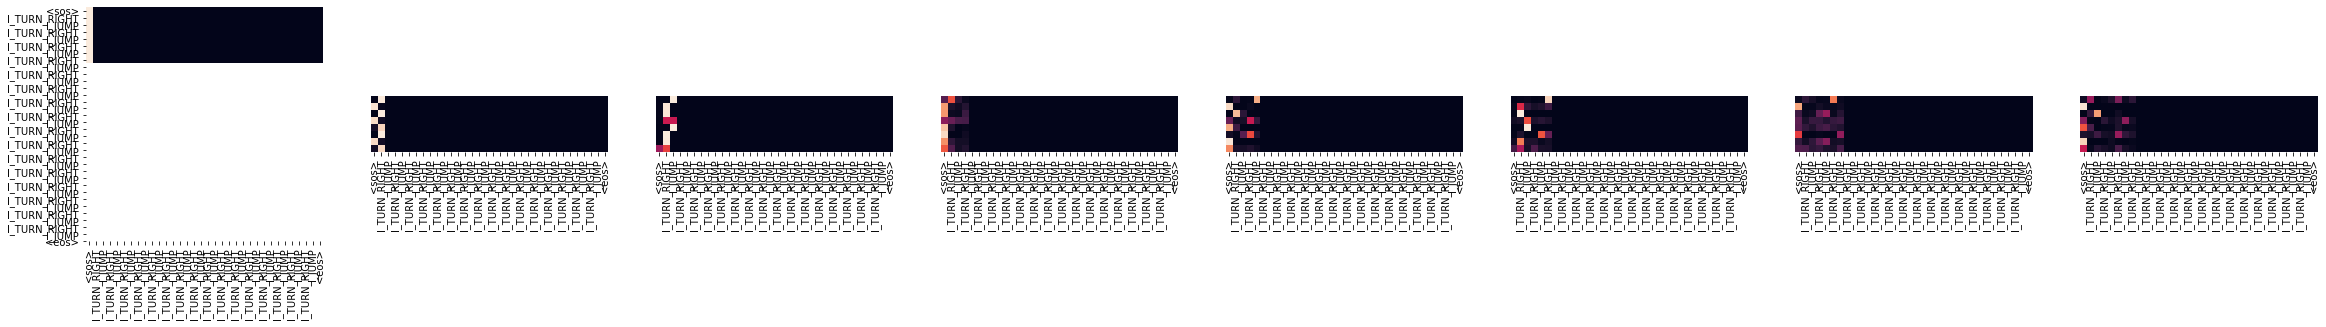

Decoder Self Attention Layer 6


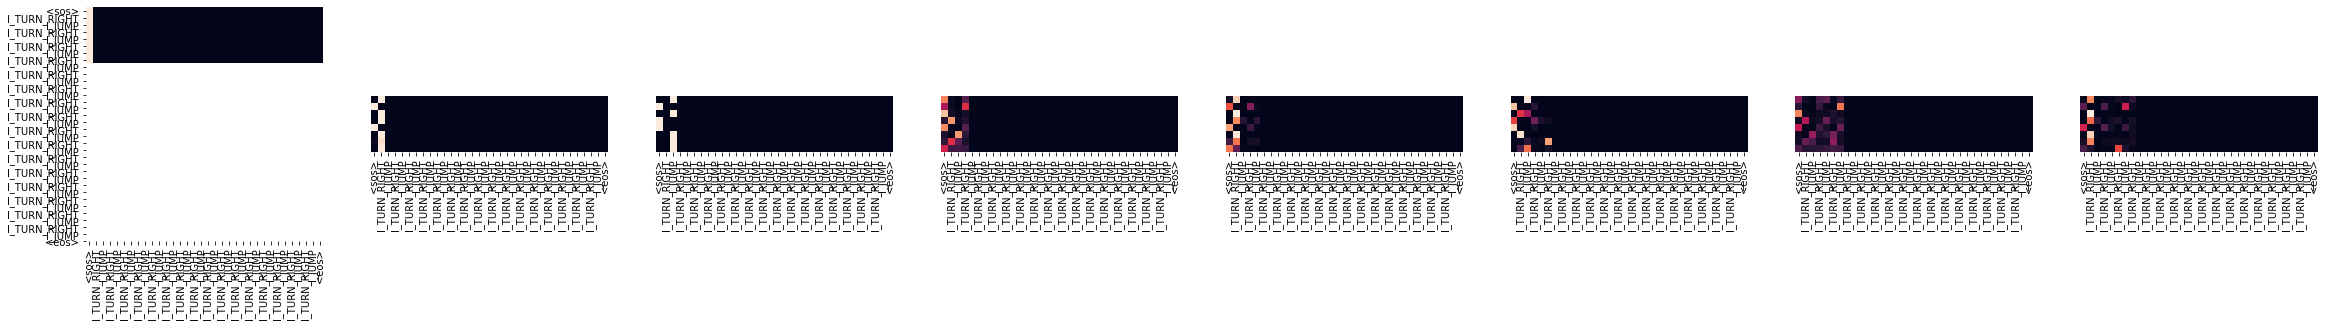

In [31]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 8, figsize=(40, 40))
    print(f"Decoder Self Attention Layer {layer + 1}")
    for h in range(8):
        draw(attn_wts.get('Decoder')[layer].get('Sublayer1')[2][:, h, :][:len(tt), :len(tt)], 
             tt, tt if h == 0 else [], ax=axs[h])
    plt.show()

Decoder MHA Layer 1


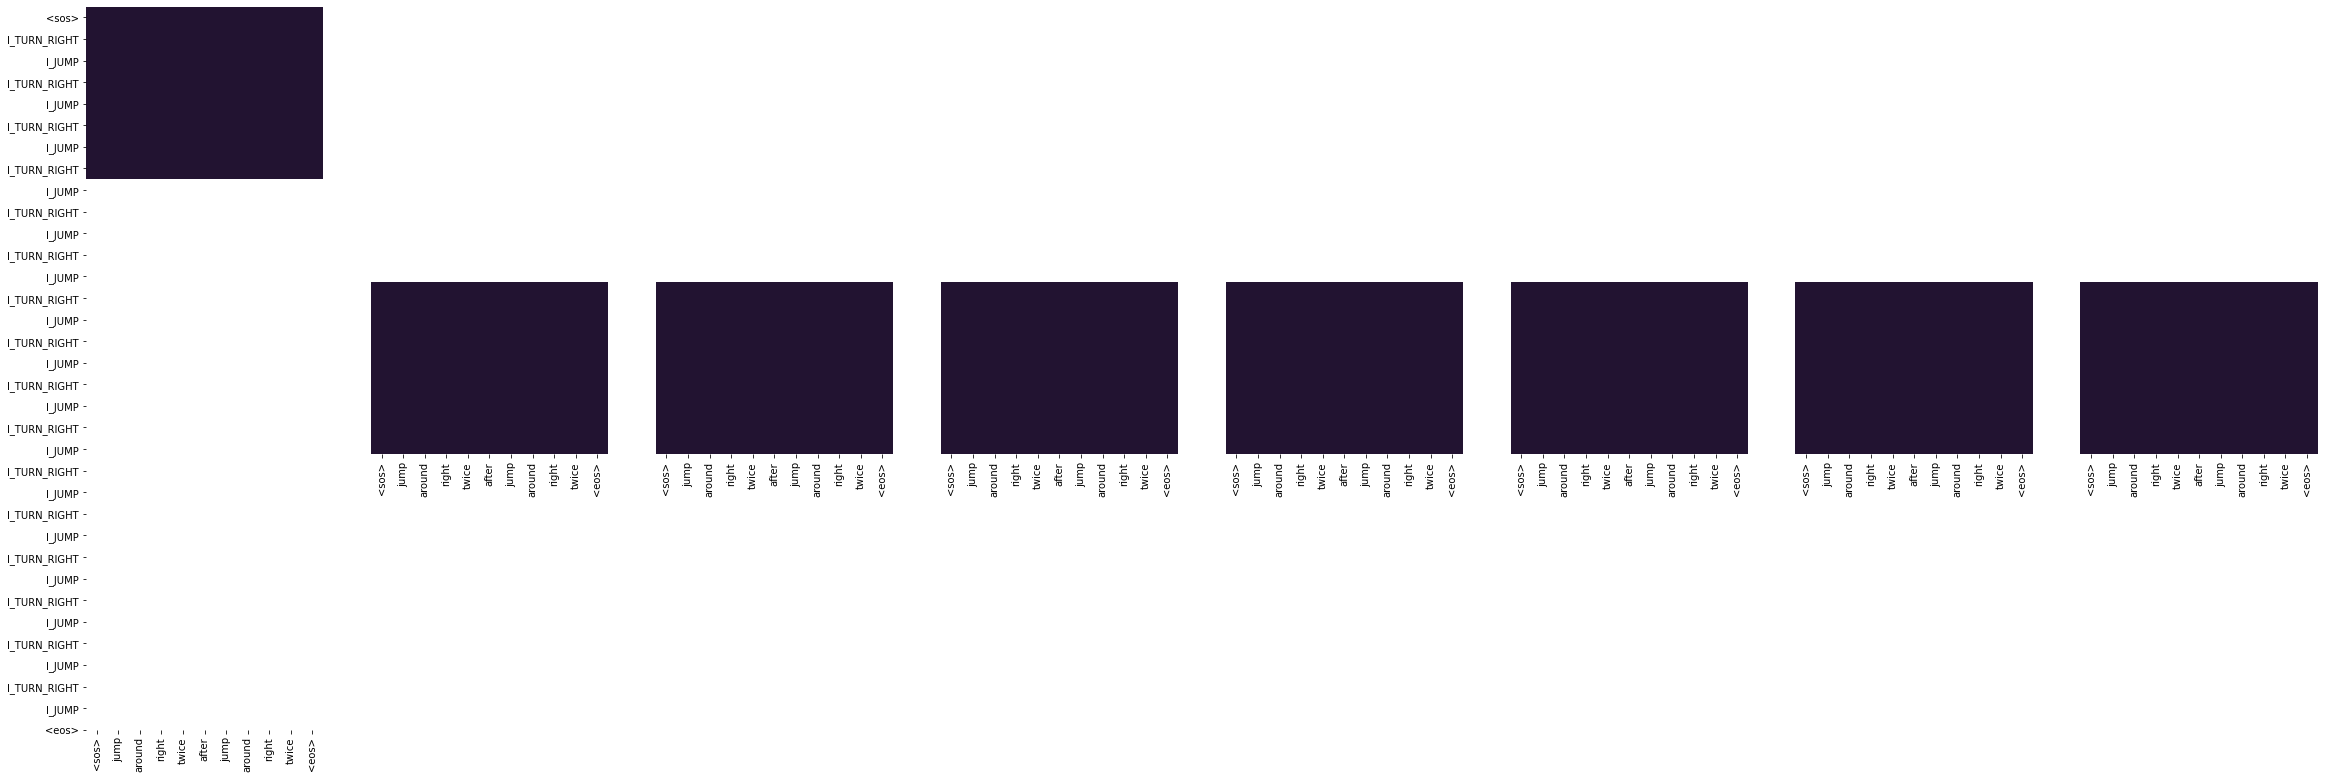

Decoder MHA Layer 2


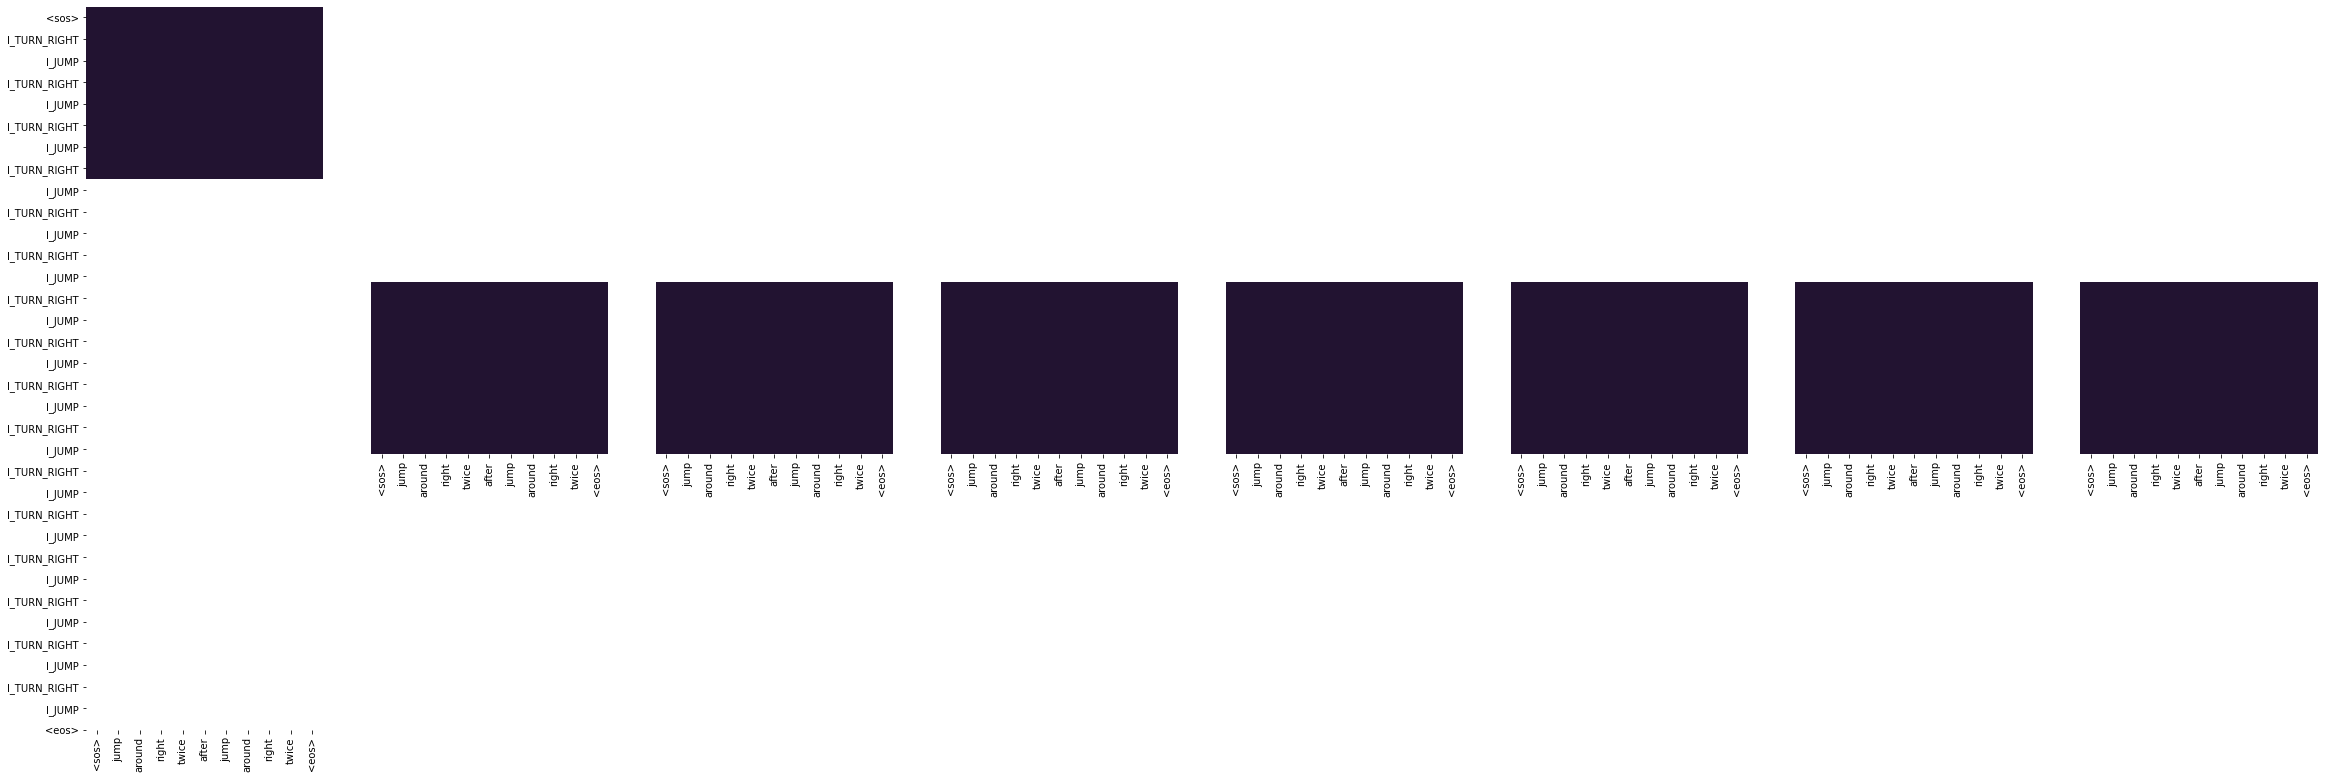

Decoder MHA Layer 3


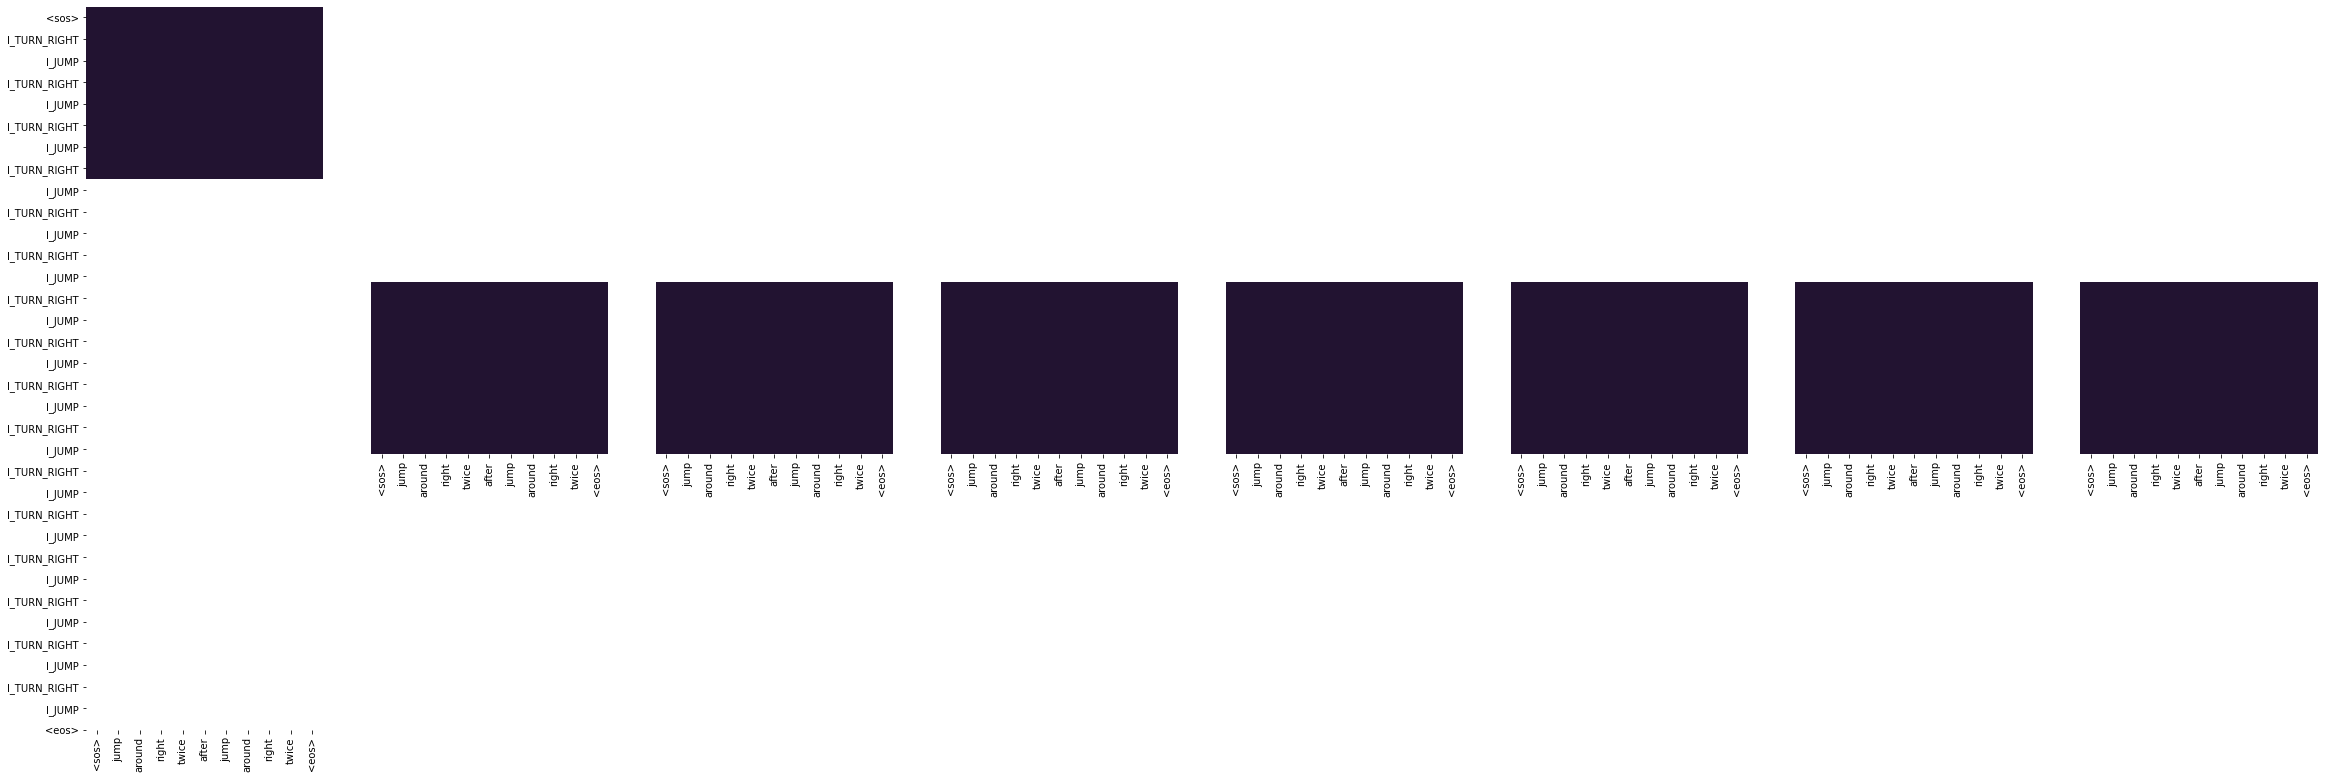

Decoder MHA Layer 4


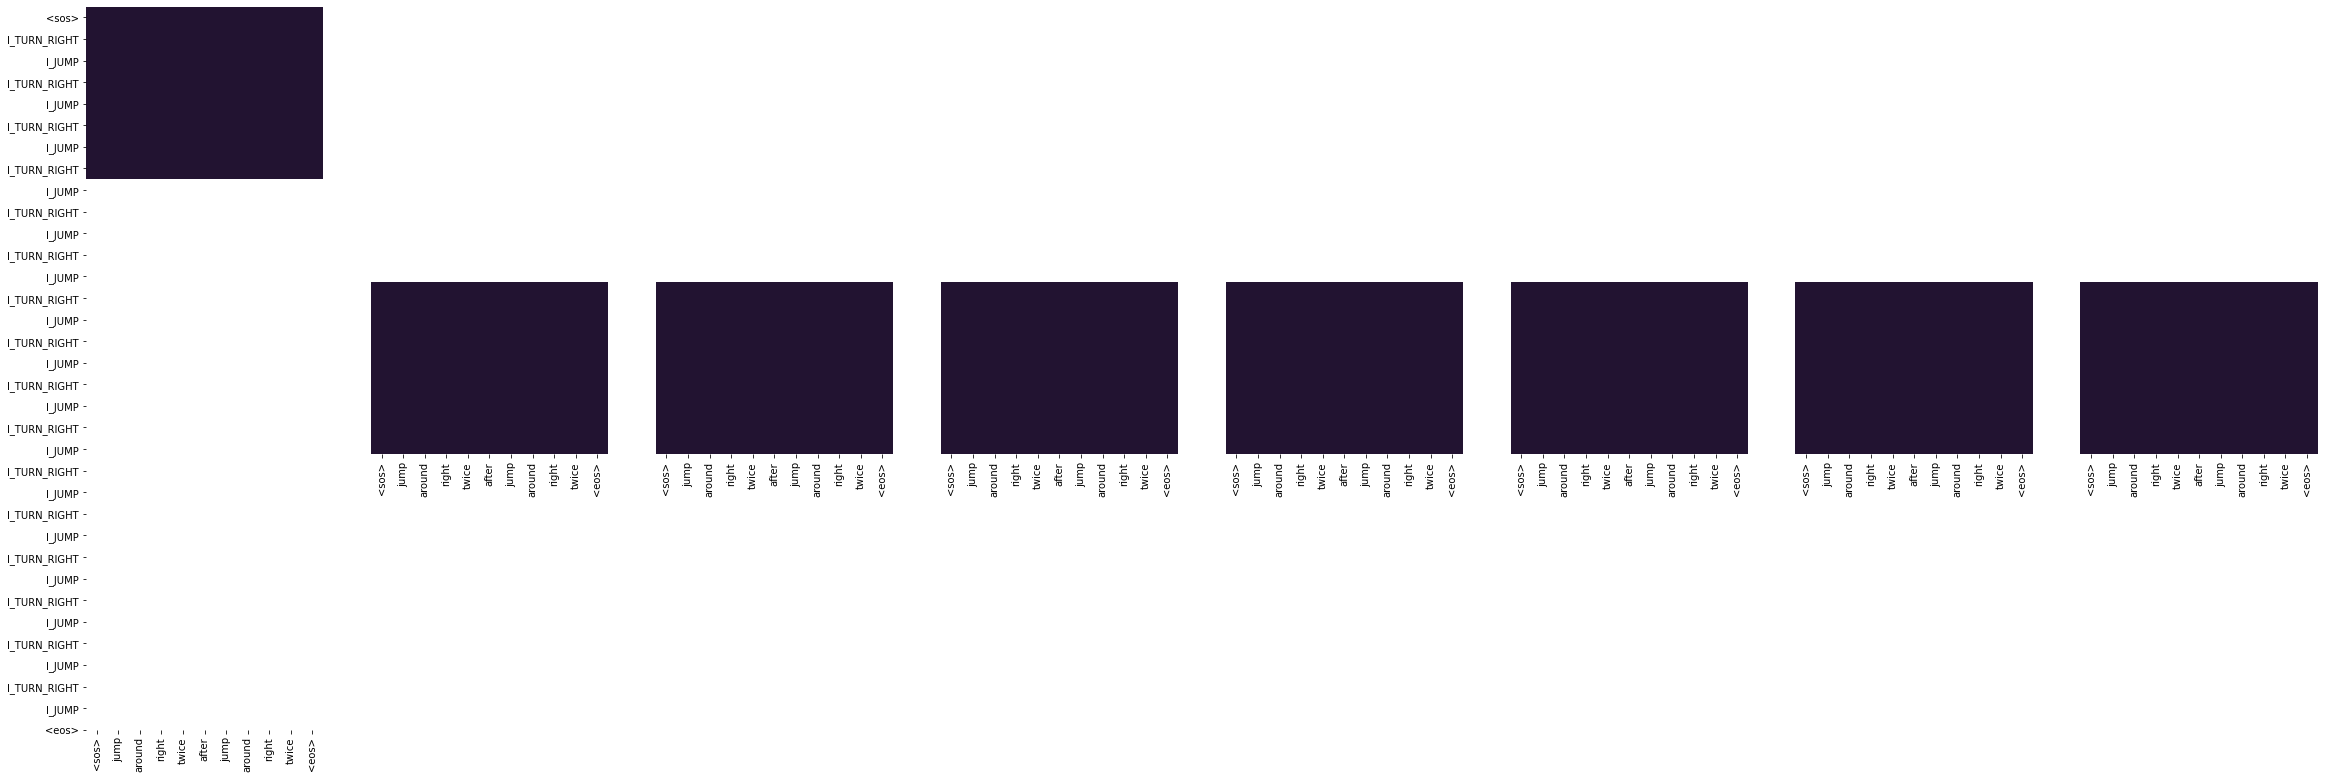

Decoder MHA Layer 5


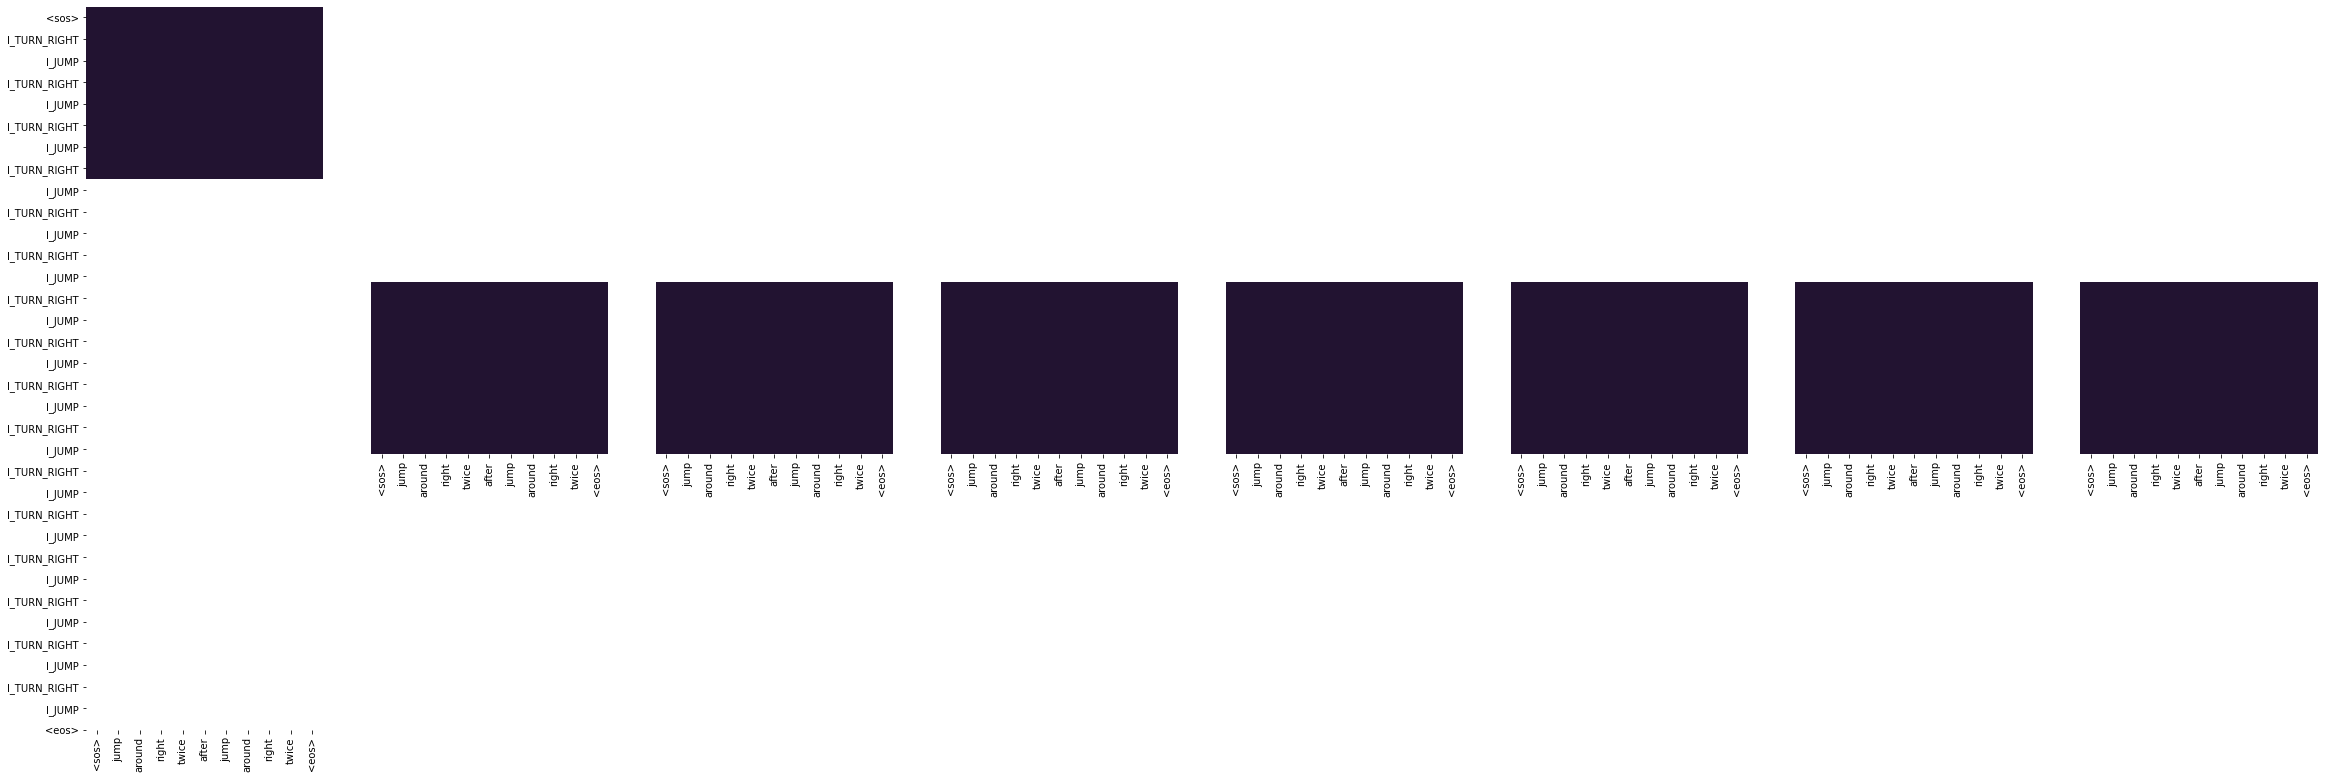

Decoder MHA Layer 6


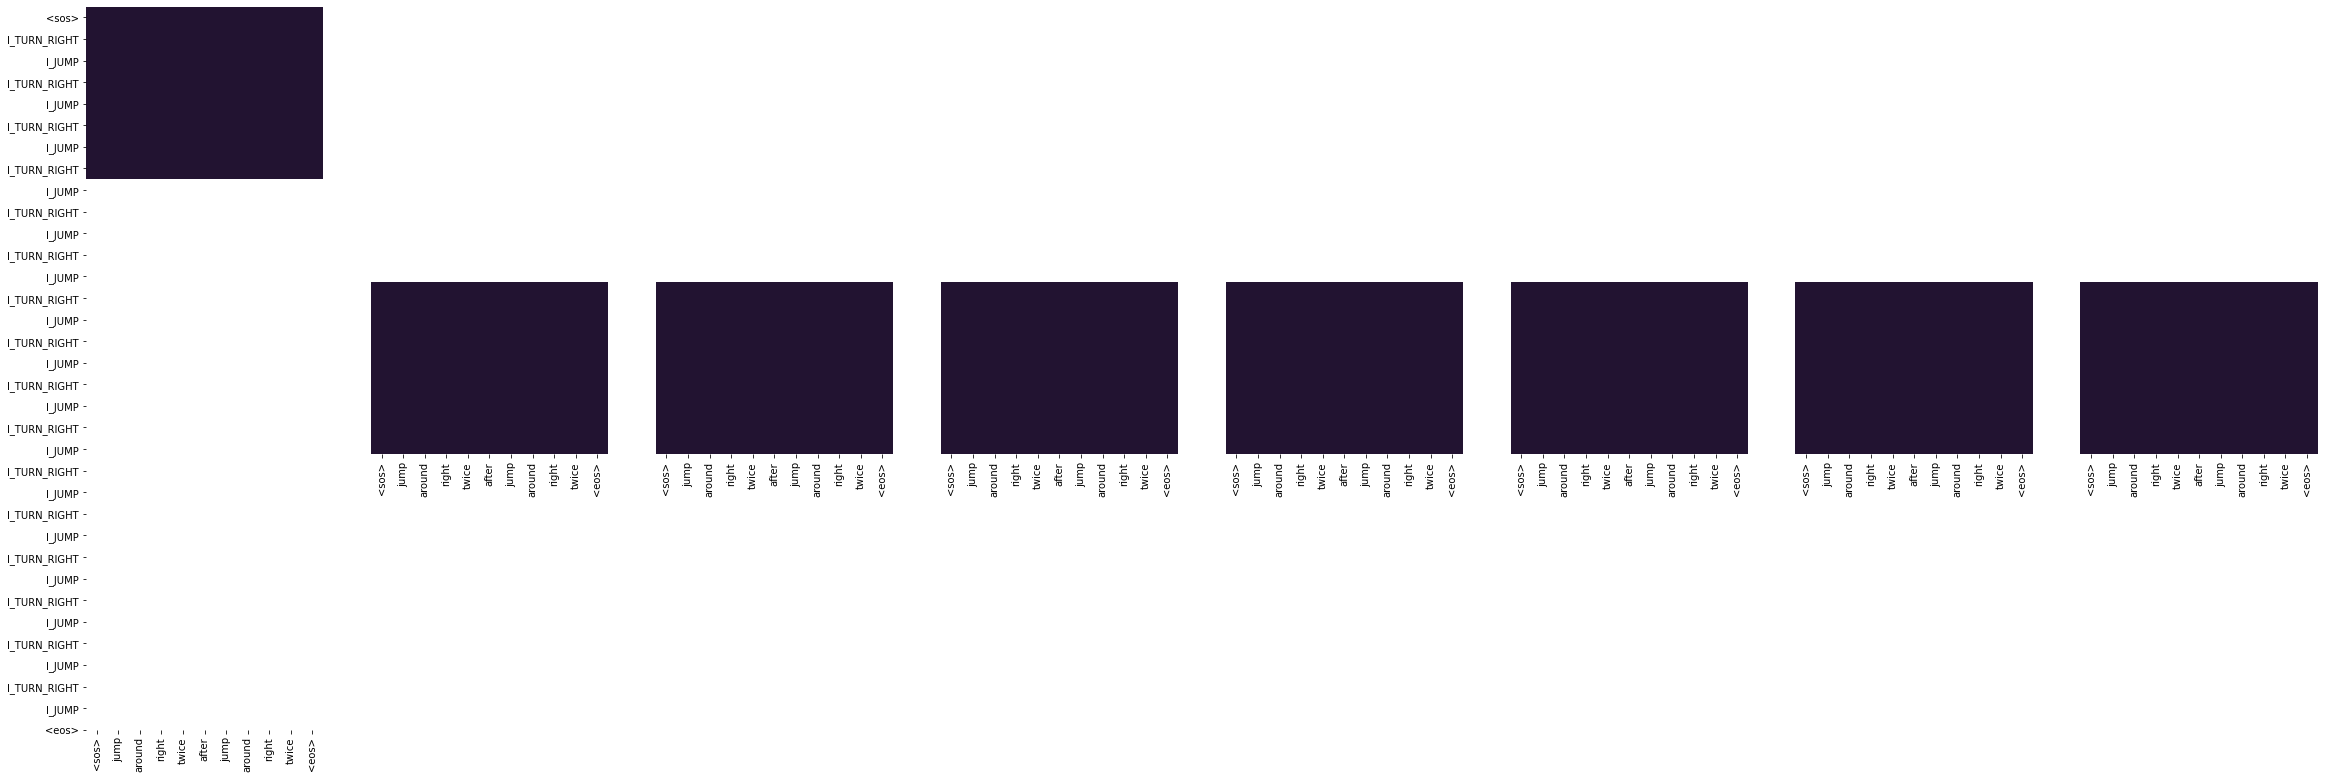

In [32]:
for layer in range(0, 6, 1):
    fig, axs = plt.subplots(1, 8, figsize=(40, 40))
    print(f"Decoder MHA Layer {layer + 1}")
    for h in range(8):
        draw(attn_wts.get('Decoder')[layer].get('Sublayer2')[2][:, h, :][:len(tt), :len(ss)],
             ss, tt if h == 0 else [], ax=axs[h])
    plt.show()

In [63]:
src_sent = []
trg_sent = []
src_pos_sent = []
trg_pos_sent = []
preds_sent = []

In [64]:
for batch in srcs:
    for s in batch:
        source = '<sos> '
        for i in range(1, s.shape[0]):
            sym = SRC.vocab.itos[s[i]]
            if sym == '<eos>': break
            source += sym + ' '
        source += '<eos>'
        ss = source
        src_sent.append(ss)

In [65]:
for batch in trgs:
    for s in batch:
        source = '<sos> '
        for i in range(1, s.shape[0]):
            sym = TRG.vocab.itos[s[i]]
            if sym == '<eos>': break
            source += sym + ' '
        source += '<eos>'
        ss = source
        trg_sent.append(ss)

In [66]:
for batch in src_poss:
    for s in batch:
        source = '<sos> '
        for i in range(1, s.shape[0]):
            sym = SRC_pos.vocab.itos[s[i]]
            if sym == '<eos>': break
            source += sym + ' '
        source += '<eos>'
        ss = source
        src_pos_sent.append(ss)

In [67]:
for batch in trg_poss:
    for s in batch:
        source = '<sos> '
        for i in range(1, s.shape[0]):
            sym = TRG_pos.vocab.itos[s[i]]
            if sym == '<eos>': break
            source += sym + ' '
        source += '<eos>'
        ss = source
        trg_pos_sent.append(ss)

In [68]:
for batch in preds:
    for s in batch:
        source = '<sos> '
        for i in range(1, s.shape[0]):
            sym = TRG.vocab.itos[s[i]]
            if sym == '<eos>': break
            source += sym + ' '
        source += '<eos>'
        ss = source
        preds_sent.append(ss)

In [83]:
print(src_sent[21]) 
print(trg_pos_sent[21])
print(trg_sent[21]) 
print(preds_sent[21])

<sos> walk opposite right twice and jump opposite right <eos>
<sos> I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM I_TURN_RIGHT I_TURN_RIGHT PRIM <eos>
<sos> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_JUMP <eos>
<sos> I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <eos>


In [84]:
model

Seq2Seq(
  (embedding): EmbeddingMultilinearSinusoidal(
    (dropout): Dropout(p=0.1, inplace=False)
    (x_embedding): Embedding(17, 256)
    (m_embedding): Embedding(17, 256)
    (linear): Linear(in_features=256, out_features=256, bias=True)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (x_layernorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (m_layernorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (MHA): SelfAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=True)
          (W_k): Linear(in_features=256, out_features=256, bias=True)
          (W_v): Linear(in_features=256, out_features=256, bias=True)
          (W_xo): Linear(in_features=256, out_features=256, bias=True)
          (W_mo): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (x_dropout1): Dropout(p=0.1, inplace=False)
        (m_dropout1): Dropou